In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')


# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [2]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [3]:
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    print(tabulate(table,  headers='keys', tablefmt='fancy_grid', showindex = True))
    return table    

In [4]:
#results paths:
path = os.getcwd()
processed_path = f"{path}/../data/mouse_kidney/processed/"

In [5]:
#scanpy config.
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.11 louvain==0.8.0 pynndescent==0.5.8


Importing both datasets SN, SC and Bulk from same mouse:

In [6]:
#reading in the combined data (normalized separately) processed in R Seurat
sn_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SN_FANS_3×500g.txt.gz"
sn_adata = sc.read_text(sn_path)
sn_adata

AnnData object with n_obs × n_vars = 16524 × 8611

In [7]:
sc_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SC_ColdDiss_Fresh.txt.gz"
sc_adata = sc.read_text(sc_path)
sc_adata

AnnData object with n_obs × n_vars = 14310 × 4606

In [8]:
bulk_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_BulkSeq_ColdDiss_Fresh.txt.gz"
bulk_adata = sc.read_text(bulk_path, delimiter=None)
bulk_adata

AnnData object with n_obs × n_vars = 29071 × 1

In [9]:
#all datasets need transposing:
sn_adata = sn_adata.transpose()
sc_adata = sc_adata.transpose()
bulk_adata = bulk_adata.transpose()

In [10]:
sn_adata.obs

Empty DataFrame
Columns: []
Index: [MJ06_SN_AAACCTGAGATCCCGC, MJ06_SN_AAACCTGAGCCACTAT, MJ06_SN_AAACCTGAGCGTGAAC, MJ06_SN_AAACCTGAGTACGCGA, MJ06_SN_AAACCTGCAACACCTA, MJ06_SN_AAACCTGCAATAACGA, MJ06_SN_AAACCTGCAATCTGCA, MJ06_SN_AAACCTGCACGGTAAG, MJ06_SN_AAACCTGCACTCAGGC, MJ06_SN_AAACCTGGTAAGGATT, MJ06_SN_AAACCTGGTACAGCAG, MJ06_SN_AAACCTGGTACCTACA, MJ06_SN_AAACCTGGTACTTGAC, MJ06_SN_AAACCTGGTCACCTAA, MJ06_SN_AAACCTGGTCGGCATC, MJ06_SN_AAACCTGGTCTAACGT, MJ06_SN_AAACCTGGTGTTTGGT, MJ06_SN_AAACCTGGTTTGTTTC, MJ06_SN_AAACCTGTCAAGCCTA, MJ06_SN_AAACCTGTCAGTTTGG, MJ06_SN_AAACCTGTCGGCGGTT, MJ06_SN_AAACCTGTCTCACATT, MJ06_SN_AAACCTGTCTCGAGTA, MJ06_SN_AAACGGGAGATCCTGT, MJ06_SN_AAACGGGAGCTAACAA, MJ06_SN_AAACGGGAGGACATTA, MJ06_SN_AAACGGGAGGCATTGG, MJ06_SN_AAACGGGAGGCCCTCA, MJ06_SN_AAACGGGAGGGATGGG, MJ06_SN_AAACGGGAGGGTCGAT, MJ06_SN_AAACGGGAGTGTTAGA, MJ06_SN_AAACGGGCAACACGCC, MJ06_SN_AAACGGGCAAGCGCTC, MJ06_SN_AAACGGGCACGGTAGA, MJ06_SN_AAACGGGCAGTGAGTG, MJ06_SN_AAACGGGCATTCACTT, MJ06_SN_AAACGGGGTCGCGAAA, MJ06_SN_AAACGGGGTTCCATGA, MJ06_SN_AAACGGGGTTGCTCCT, MJ06_SN_AAACGGGTCACCACCT, MJ06_SN_AAACGGGTCATTCACT, MJ06_SN_AAACGGGTCCGAATGT, MJ06_SN_AAACGGGTCGGCGGTT, MJ06_SN_AAACGGGTCGTACCGG, MJ06_SN_AAACGGGTCTTCCTTC, MJ06_SN_AAAGATGAGAGAACAG, MJ06_SN_AAAGATGAGCCACGTC, MJ06_SN_AAAGATGAGCTACCGC, MJ06_SN_AAAGATGAGCTCCTCT, MJ06_SN_AAAGATGAGGCCCTCA, MJ06_SN_AAAGATGCAACACCCG, MJ06_SN_AAAGATGCAAGCTGTT, MJ06_SN_AAAGATGCACATGACT, MJ06_SN_AAAGATGCACGACTCG, MJ06_SN_AAAGATGCAGCTGCAC, MJ06_SN_AAAGATGCAGTCGTGC, MJ06_SN_AAAGATGCATCATCCC, MJ06_SN_AAAGATGCATCGGACC, MJ06_SN_AAAGATGGTACGCTGC, MJ06_SN_AAAGATGGTTCATGGT, MJ06_SN_AAAGATGGTTCGCTAA, MJ06_SN_AAAGATGTCACGCGGT, MJ06_SN_AAAGATGTCGGCGCAT, MJ06_SN_AAAGATGTCGGTCCGA, MJ06_SN_AAAGCAAAGAGACTAT, MJ06_SN_AAAGCAAAGGTGTTAA, MJ06_SN_AAAGCAAAGTAGCGGT, MJ06_SN_AAAGCAAAGTTAACGA, MJ06_SN_AAAGCAACAAGGCTCC, MJ06_SN_AAAGCAACACAGTCGC, MJ06_SN_AAAGCAACACATTAGC, MJ06_SN_AAAGCAACAGACTCGC, MJ06_SN_AAAGCAACAGTCACTA, MJ06_SN_AAAGCAACATATACCG, MJ06_SN_AAAGCAAGTCCATCCT, MJ06_SN_AAAGCAAGTCGCTTTC, MJ06_SN_AAAGCAAGTGCAGACA, MJ06_SN_AAAGCAAGTGGGTATG, MJ06_SN_AAAGCAAGTTCAGCGC, MJ06_SN_AAAGCAAGTTCAGTAC, MJ06_SN_AAAGCAATCAACCATG, MJ06_SN_AAAGCAATCACTTATC, MJ06_SN_AAAGCAATCCACGTGG, MJ06_SN_AAAGCAATCCTGCAGG, MJ06_SN_AAAGCAATCCTTTACA, MJ06_SN_AAAGCAATCTACGAGT, MJ06_SN_AAAGCAATCTCTGCTG, MJ06_SN_AAAGCAATCTGGTTCC, MJ06_SN_AAAGCAATCTTGCATT, MJ06_SN_AAAGTAGAGCAGACTG, MJ06_SN_AAAGTAGAGCTGTTCA, MJ06_SN_AAAGTAGCAAGCCTAT, MJ06_SN_AAAGTAGCAAGGACTG, MJ06_SN_AAAGTAGCACATGACT, MJ06_SN_AAAGTAGCACCAGCAC, MJ06_SN_AAAGTAGCACCAGTTA, MJ06_SN_AAAGTAGCACGTGAGA, MJ06_SN_AAAGTAGCAGACGCTC, MJ06_SN_AAAGTAGGTAAGAGAG, MJ06_SN_AAAGTAGGTACCAGTT, ...]

[8611 rows x 0 columns]

In [11]:
sn_adata.var_names_make_unique()
sc_adata.var_names_make_unique()  

Assigning cell types to each:

In [12]:
#importing the paper's excel sheet with cell types:
cell_path = f"{path}/../data/mouse_kidney/cell_assignments/13059_2020_2048_MOESM3_ESM.xlsx"
cell_assign_sn = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v2_chemistry')
cell_assign_sn

Unnamed: 0 Library           Protocol Cell type
0      MJ03_BG70_AAACCTGAGCTGCAAG    MJ03              SC_v2        PT
1      MJ03_BG70_AAACCTGAGCTGCGAA    MJ03              SC_v2        PT
2      MJ03_BG70_AAACCTGCAAGTACCT    MJ03              SC_v2        PT
3      MJ03_BG70_AAACGGGAGATCCGAG    MJ03              SC_v2        PT
4      MJ03_BG70_AAACGGGAGATGAGAG    MJ03              SC_v2        PT
...                           ...     ...                ...       ...
32997    MJ08_SN_TTTGTCACATCGGGTC    MJ08  SN_FANS_3x500g_v2      aLOH
32998    MJ08_SN_TTTGTCAGTAGCAAAT    MJ08  SN_FANS_3x500g_v2        PT
32999    MJ08_SN_TTTGTCAGTCCAGTGC    MJ08  SN_FANS_3x500g_v2        PT
33000    MJ08_SN_TTTGTCAGTTACTGAC    MJ08  SN_FANS_3x500g_v2        PT
33001    MJ08_SN_TTTGTCATCGAGGTAG    MJ08  SN_FANS_3x500g_v2      aLOH

[33002 rows x 4 columns]

In [13]:
cell_assign_sc = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v3_chemistry')
cell_assign_sc

Unnamed: 0 Library       Protocol Cell type
0      LD01_SC_FRESH_AAACCCACAACCACAT    LD01          SC_v3     CD_IC
1      LD01_SC_FRESH_AAACCCAGTATGACAA    LD01          SC_v3     CD_IC
2      LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01          SC_v3       CNT
3      LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01          SC_v3        PT
4      LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01          SC_v3     CD_PC
...                               ...     ...            ...       ...
95670      MJ59_SN_O_TTTGTTGCACCCTCTA    MJ59  SN_sucrose_v3      aLOH
95671      MJ59_SN_O_TTTGTTGCAGCATTGT    MJ59  SN_sucrose_v3        MC
95672      MJ59_SN_O_TTTGTTGGTAGCTGCC    MJ59  SN_sucrose_v3        PT
95673      MJ59_SN_O_TTTGTTGGTGTTAACC    MJ59  SN_sucrose_v3        PT
95674      MJ59_SN_O_TTTGTTGGTTGCCGCA    MJ59  SN_sucrose_v3        PT

[95675 rows x 4 columns]

In [14]:
sn_celltypes = cell_assign_sn[cell_assign_sn['Library']=='MJ06']
sn_celltypes

Unnamed: 0 Library           Protocol Cell type
9153   MJ06_SN_AAACCTGAGATCCCGC    MJ06  SN_FANS_3x500g_v2      aLOH
9154   MJ06_SN_AAACCTGAGCCACTAT    MJ06  SN_FANS_3x500g_v2      aLOH
9155   MJ06_SN_AAACCTGAGCGTGAAC    MJ06  SN_FANS_3x500g_v2      aLOH
9156   MJ06_SN_AAACCTGAGTACGCGA    MJ06  SN_FANS_3x500g_v2        PT
9157   MJ06_SN_AAACCTGCAACACCTA    MJ06  SN_FANS_3x500g_v2      aLOH
...                         ...     ...                ...       ...
17759  MJ06_SN_TTTGTCAGTGCAACGA    MJ06  SN_FANS_3x500g_v2        PT
17760  MJ06_SN_TTTGTCAGTTCCATGA    MJ06  SN_FANS_3x500g_v2      aLOH
17761  MJ06_SN_TTTGTCATCCTACAGA    MJ06  SN_FANS_3x500g_v2        PT
17762  MJ06_SN_TTTGTCATCGCGATCG    MJ06  SN_FANS_3x500g_v2        PT
17763  MJ06_SN_TTTGTCATCTGACCTC    MJ06  SN_FANS_3x500g_v2      aLOH

[8611 rows x 4 columns]

In [15]:
sn_celltypes['Cell type']

9153     aLOH
9154     aLOH
9155     aLOH
9156       PT
9157     aLOH
         ... 
17759      PT
17760    aLOH
17761      PT
17762      PT
17763    aLOH
Name: Cell type, Length: 8611, dtype: object

In [16]:
sn_adata.obs['cell_type'] = sn_celltypes['Cell type'].values
sn_adata.obs

cell_type
MJ06_SN_AAACCTGAGATCCCGC      aLOH
MJ06_SN_AAACCTGAGCCACTAT      aLOH
MJ06_SN_AAACCTGAGCGTGAAC      aLOH
MJ06_SN_AAACCTGAGTACGCGA        PT
MJ06_SN_AAACCTGCAACACCTA      aLOH
...                            ...
MJ06_SN_TTTGTCAGTGCAACGA        PT
MJ06_SN_TTTGTCAGTTCCATGA      aLOH
MJ06_SN_TTTGTCATCCTACAGA        PT
MJ06_SN_TTTGTCATCGCGATCG        PT
MJ06_SN_TTTGTCATCTGACCTC      aLOH

[8611 rows x 1 columns]

In [17]:
#now assigning sc cell types
sc_celltypes = cell_assign_sc[cell_assign_sc['Library']=='LD01']
sc_celltypes

Unnamed: 0 Library Protocol Cell type
0     LD01_SC_FRESH_AAACCCACAACCACAT    LD01    SC_v3     CD_IC
1     LD01_SC_FRESH_AAACCCAGTATGACAA    LD01    SC_v3     CD_IC
2     LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01    SC_v3       CNT
3     LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01    SC_v3        PT
4     LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01    SC_v3     CD_PC
...                              ...     ...      ...       ...
4601  LD01_SC_FRESH_TTTGTTGGTGAGATCG    LD01    SC_v3        PT
4602  LD01_SC_FRESH_TTTGTTGGTTTCACAG    LD01    SC_v3       CNT
4603  LD01_SC_FRESH_TTTGTTGTCCCTCGTA    LD01    SC_v3      aLOH
4604  LD01_SC_FRESH_TTTGTTGTCGAGAGAC    LD01    SC_v3      Endo
4605  LD01_SC_FRESH_TTTGTTGTCGAGATGG    LD01    SC_v3        PT

[4606 rows x 4 columns]

In [18]:
sc_adata.obs['cell_type'] = sc_celltypes['Cell type'].values
sc_adata.obs

cell_type
LD01_SC_FRESH_AAACCCACAACCACAT     CD_IC
LD01_SC_FRESH_AAACCCAGTATGACAA     CD_IC
LD01_SC_FRESH_AAACCCAGTTCAAGGG       CNT
LD01_SC_FRESH_AAACCCATCAGCTTCC        PT
LD01_SC_FRESH_AAACCCATCCTTTGAT     CD_PC
...                                  ...
LD01_SC_FRESH_TTTGTTGGTGAGATCG        PT
LD01_SC_FRESH_TTTGTTGGTTTCACAG       CNT
LD01_SC_FRESH_TTTGTTGTCCCTCGTA      aLOH
LD01_SC_FRESH_TTTGTTGTCGAGAGAC      Endo
LD01_SC_FRESH_TTTGTTGTCGAGATGG        PT

[4606 rows x 1 columns]

In [19]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)

In [20]:
sn_genes

Empty DataFrame
Columns: []
Index: [Sox17, Mrpl15, Lypla1, Tcea1, Atp6v1h, Rb1cc1, 4732440D04Rik, Pcmtd1, Rrs1, Adhfe1, Vcpip1, Sgk3, Snhg6, Tcf24, Cops5, Cspp1, Arfgef1, Prex2, Ncoa2, Tram1, Lactb2, Terf1, Rpl7, Rdh10, Stau2, Ube2w, Tceb1, Tmem70, Ly96, Tfap2b, Pkhd1, Mcm3, Tram2, Tmem14a, Gsta3, Gm29107, Ogfrl1, B3gat2, Smap1, Sdhaf4, Fam135a, Lmbrd1, Phf3, Ptp4a1, Rab23, Bag2, Zfp451, Dst, Ccdc115, Imp4, Ptpn18, Fam168b, Plekhb2, Hs6st1, Uggt1, Neurl3, Arid5a, Kansl3, Lman2l, Cnnm4, Cnnm3, Ankrd39, Sema4c, Cox5b, Actr1b, Tmem131, Inpp4a, Coa5, Unc50, Mgat4a, Tsga10, Lipt1, Mitd1, Mrpl30, Txndc9, Eif5b, Rev1, Pdcl3, Rpl31, Cnot11, Rnf149, Map4k4, Il1r1, Il18r1, Slc9a2, Mfsd9, Pantr1, Pou3f3, Mrps9, Tgfbrap1, AI597479, Fhl2, Nck2, Uxs1, Tpp2, Tex30, Bivm, Ercc5, Gulp1, Col5a2, ...]

[16524 rows x 0 columns]

In [21]:
sc_genes

Empty DataFrame
Columns: []
Index: [Sox17, Mrpl15, Lypla1, Tcea1, Atp6v1h, Rb1cc1, 4732440D04Rik, Pcmtd1, Rrs1, Adhfe1, Vcpip1, 1700034P13Rik, Sgk3, Mcmdc2, Snhg6, Tcf24, Ppp1r42, Cops5, Cspp1, Arfgef1, Prex2, Sulf1, Ncoa2, Tram1, Lactb2, Terf1, Sbspon, 4930444P10Rik, Rpl7, Rdh10, Stau2, Ube2w, Tceb1, Tmem70, Ly96, Jph1, Pi15, Crispld1, Tfap2b, Pkhd1, Mcm3, Efhc1, Tram2, Tmem14a, Gsta3, Gm29107, Ogfrl1, B3gat2, Smap1, Sdhaf4, Fam135a, Lmbrd1, Gm5524, Phf3, Ptp4a1, Prim2, Rab23, Bag2, Zfp451, Dst, Ccdc115, Imp4, Ptpn18, Arhgef4, Fam168b, Plekhb2, Hs6st1, Uggt1, Neurl3, Arid5a, Kansl3, Lman2l, Cnnm4, Cnnm3, Ankrd39, Sema4c, Cox5b, Actr1b, Tmem131, Inpp4a, Coa5, Unc50, Mgat4a, Tsga10, Lipt1, Mitd1, Mrpl30, Txndc9, Eif5b, Rev1, Pdcl3, Npas2, Rpl31, Tbc1d8, Cnot11, Rnf149, Map4k4, Il1r1, Il18r1, Il18rap, ...]

[14310 rows x 0 columns]

In [22]:
bulk_genes

Empty DataFrame
Columns: []
Index: [Xkr4, RP23-317L18.4, RP23-317L18.3, RP23-115I1.2, RP23-122M2.3, Rp1, RP23-177A20.1, Sox17, RP23-285G23.2, RP23-285G23.3, Gm22307, RP23-285G23.4, Gm37323, RP23-37D15.2, Gm6085, RP23-34E15.2, RP23-34E15.3, RP23-34E15.4, Mrpl15, RP23-34E15.5, Lypla1, Gm37988, Tcea1, Gm6104, RP24-426M1.4, Rgs20, Atp6v1h, Rb1cc1, 4732440D04Rik, Fam150a, RP23-76C20.3, RP23-76C20.2, RP23-76C20.4, RP23-5K7.4, Pcmtd1, Gm26983, WI1-817D1.2, Gm9826, Gm26901, Gm30414, RP23-404K2.1, RP23-408B17.1, Sntg1, Gm16284, RP23-311L17.1, RP24-442E5.1, Gm15452, RP23-397E23.1, Gm24276, Gm7493, RP23-331M15.1, RP23-331M15.2, RP23-411P10.5, RP23-411P10.2, RP24-361E12.1, Rrs1, Adhfe1, 2610203C22Rik, Gm6161, 3110035E14Rik, Mybl1, Vcpip1, 1700034P13Rik, Sgk3, Mcmdc2, Snhg6, Snord87, Tcf24, RP23-228G18.3, Ppp1r42, Gm15818, Cops5, Cspp1, Arfgef1, RP24-327F2.1, Gm15604, Gm15603, Gm28659, Prex2, Gm28686, A830018L16Rik, RP23-2K13.1, Gm7560, Gm22633, Gm2383, Sulf1, Slco5a1, Prdm14, Ncoa2, RP23-93D12.2, RP23-93D12.1, RP23-125I14.3, Gm23169, RP23-125I14.2, RP23-125I14.1, Gm29570, Gm7593, Tram1, Lactb2, RP23-70F22.2, ...]

[29071 rows x 0 columns]

In [23]:
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [24]:
common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)
common_genes

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [25]:
common_genes_wbulk = np.intersect1d(common_genes, bulk_genes.columns)
common_genes_wbulk = list(common_genes_wbulk)
common_genes_wbulk

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [26]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

In [27]:
#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

13686

In [28]:
#common genes between SN and SC only, no bulk.
len(common_genes)

13707

In [29]:
#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

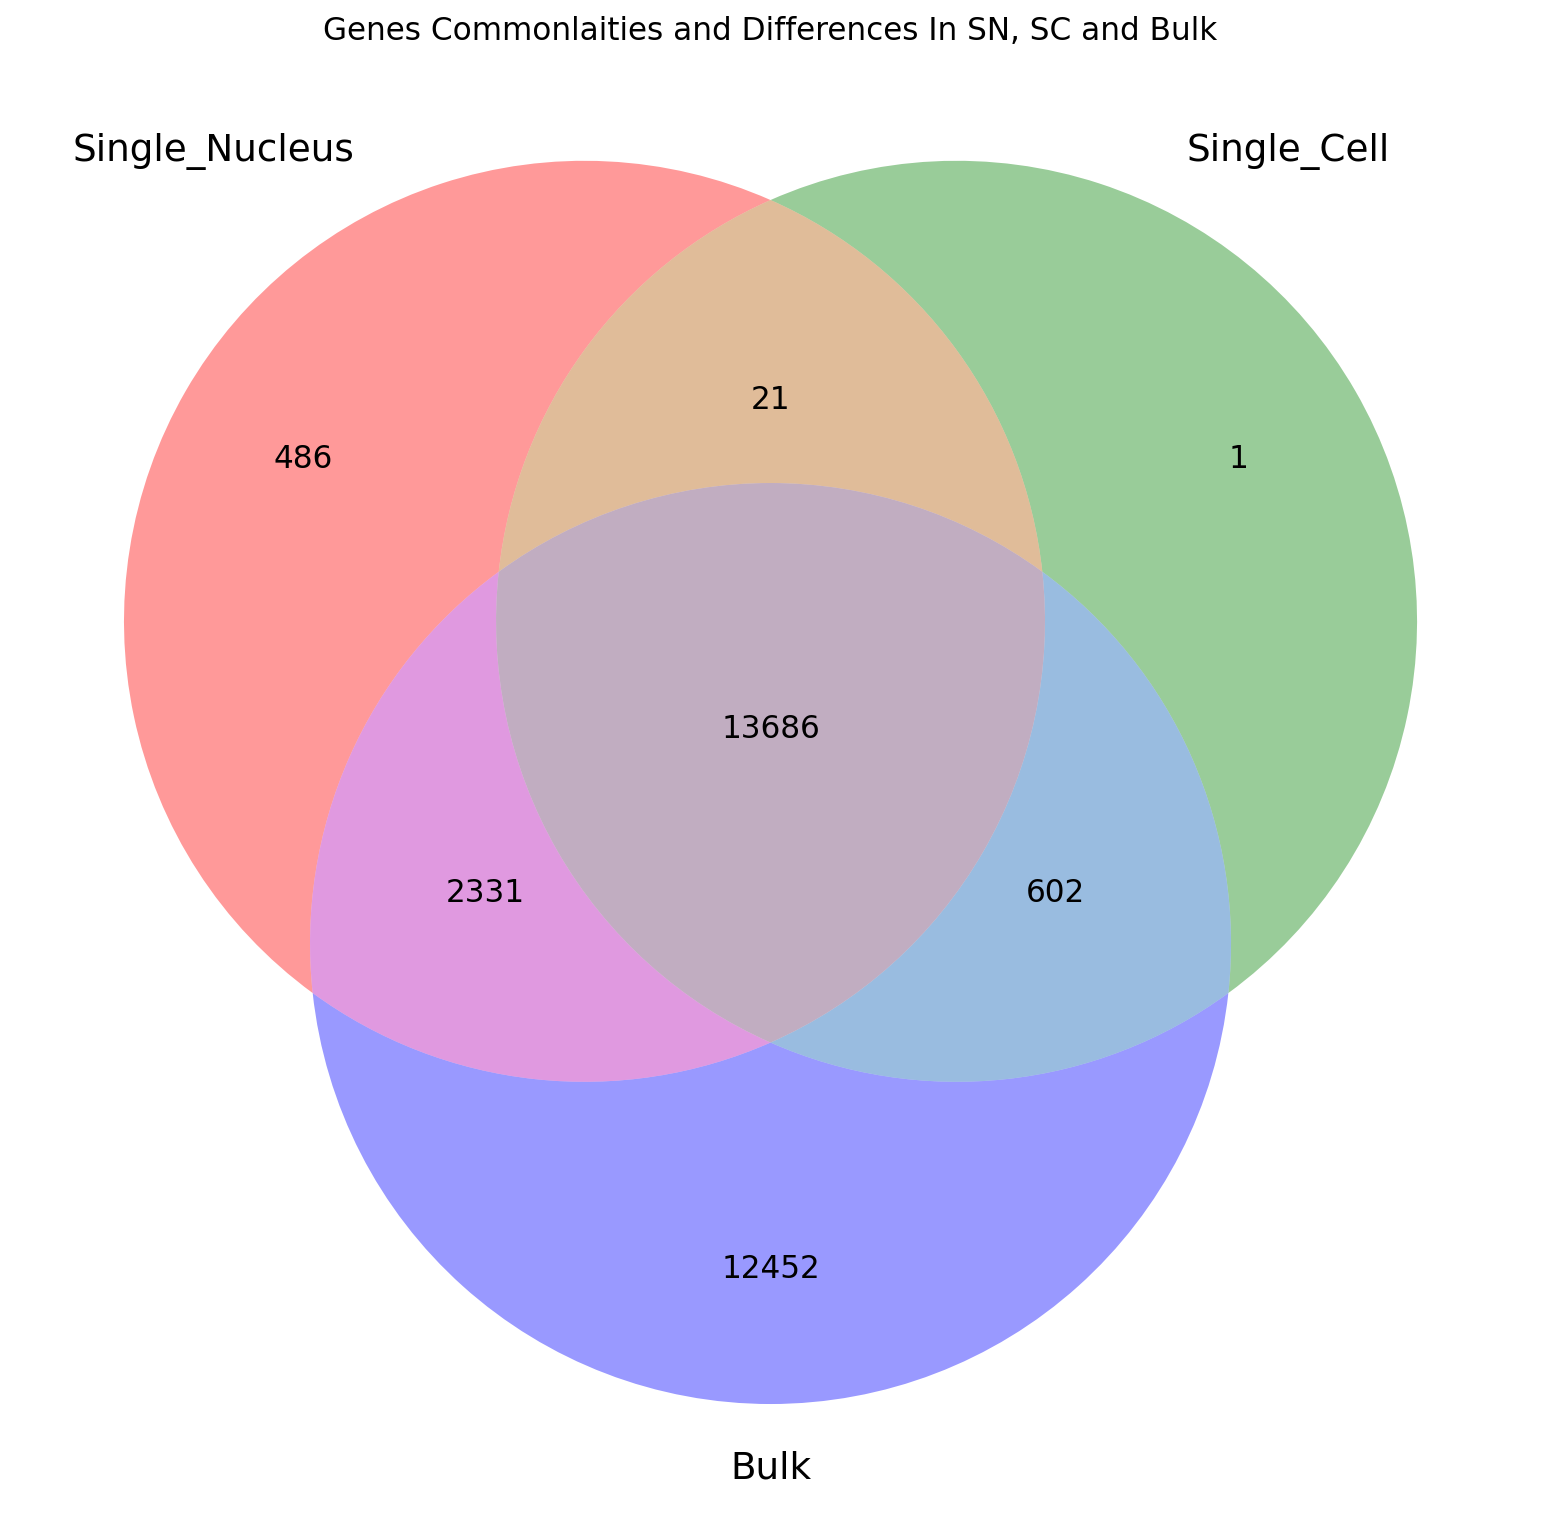

In [30]:
#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk")                  
plt.show()

In [31]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sc_adata to contain only the genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sc_adata.var_names, common_genes)
sc_adata = sc_adata[:, common_gene_indicator]
sc_adata

View of AnnData object with n_obs × n_vars = 4606 × 13707
    obs: 'cell_type'

In [32]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sn_adta to contain only genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sn_adata.var_names, common_genes)
sn_adata = sn_adata[:, common_gene_indicator]
sn_adata

View of AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type'

QCing the single nucleus data first:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


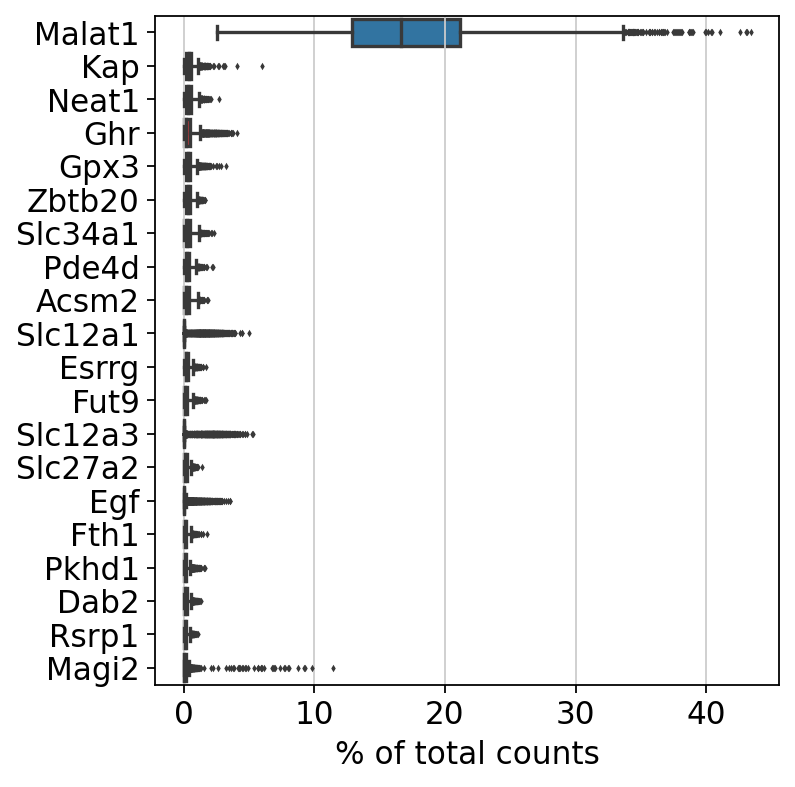

In [33]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [34]:
#sc.pp.filter_cells(sn_adata, min_genes=200)
#sc.pp.filter_genes(sn_adata, min_cells=3)

In [35]:
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


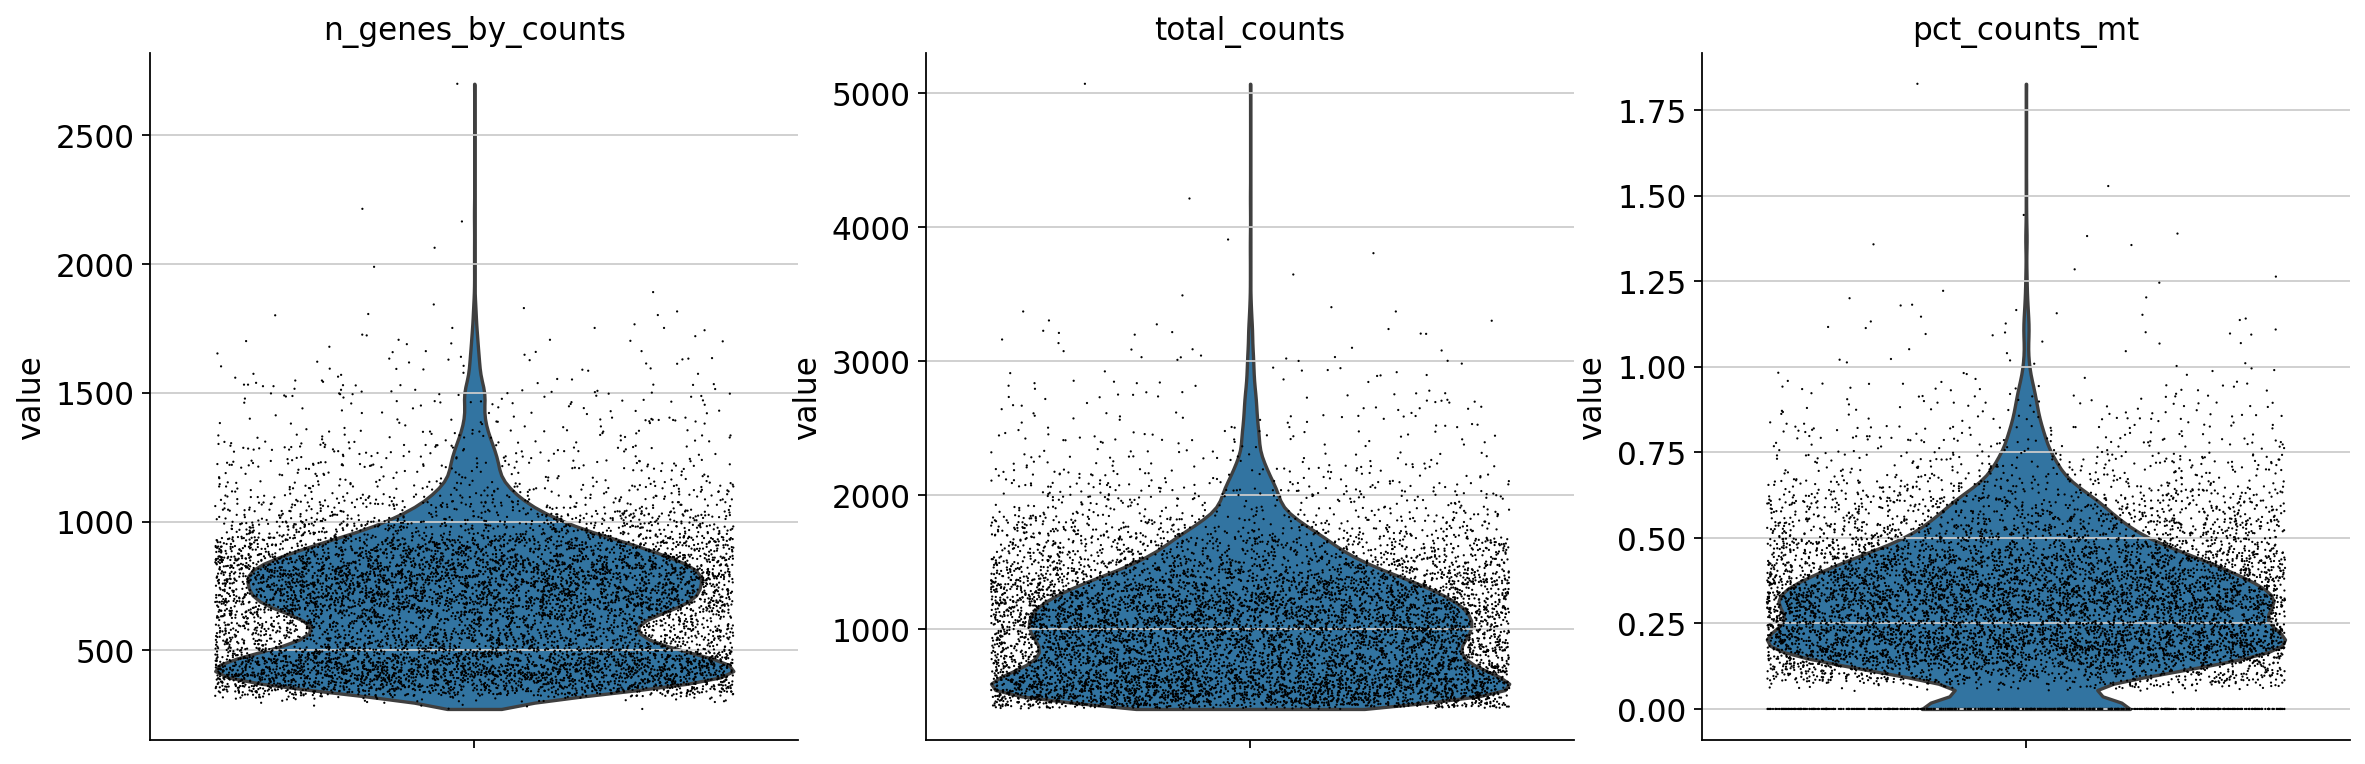

In [36]:
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

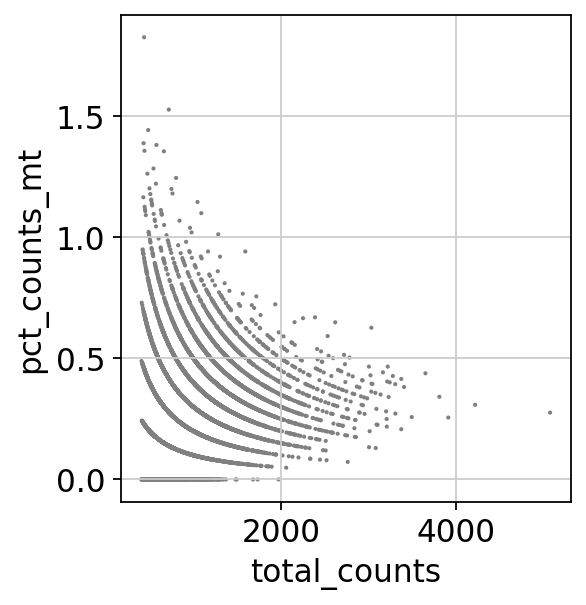

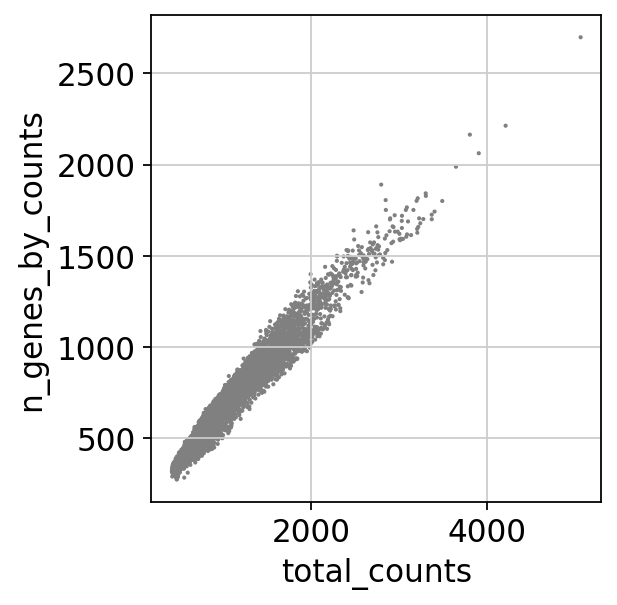

In [37]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [38]:
#sn_data = sn_adata[sn_adata.obs.n_genes_by_counts < 2000, :]
#sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 1.5, :]

In [39]:
sn_adata

AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [40]:
#sc.pp.normalize_total(sn_adata, target_sum=1e4)
sc.pp.log1p(sn_adata)

In [41]:
sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


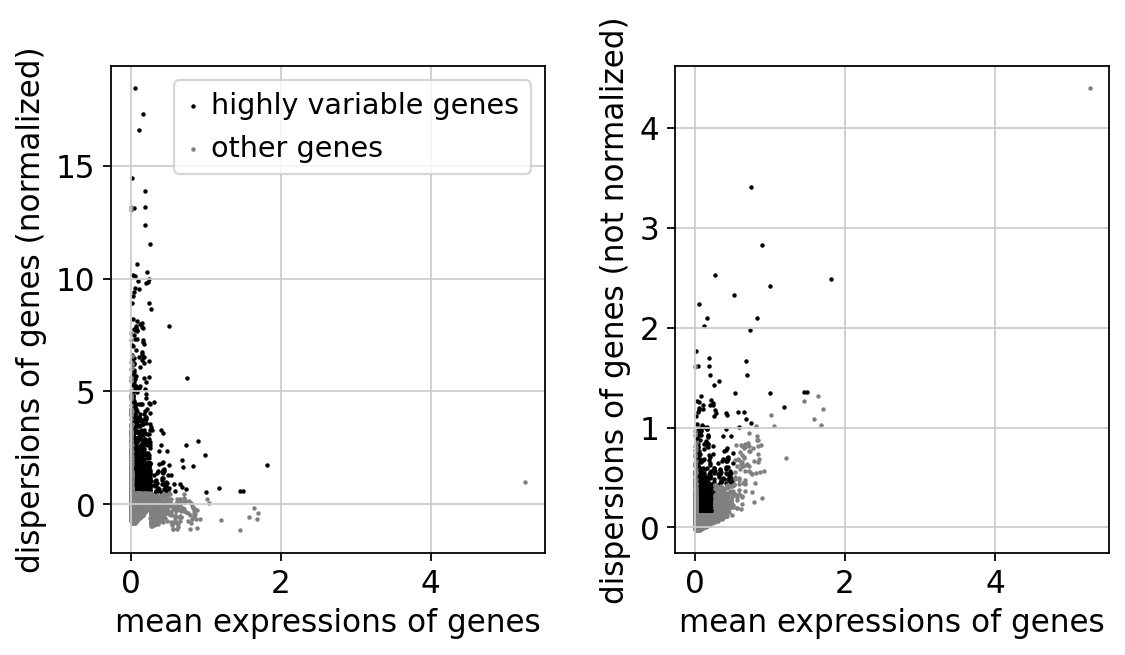

In [42]:
sc.pl.highly_variable_genes(sn_adata)

In [43]:
#sn_adata = sn_adata[:, sn_adata.var.highly_variable]

In [44]:
#sc.pp.regress_out(sn_adata, ['total_counts', 'pct_counts_mt'])

In [45]:
#sc.pp.scale(sn_adata, max_value=10)

Now QC the single-cell dataset:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


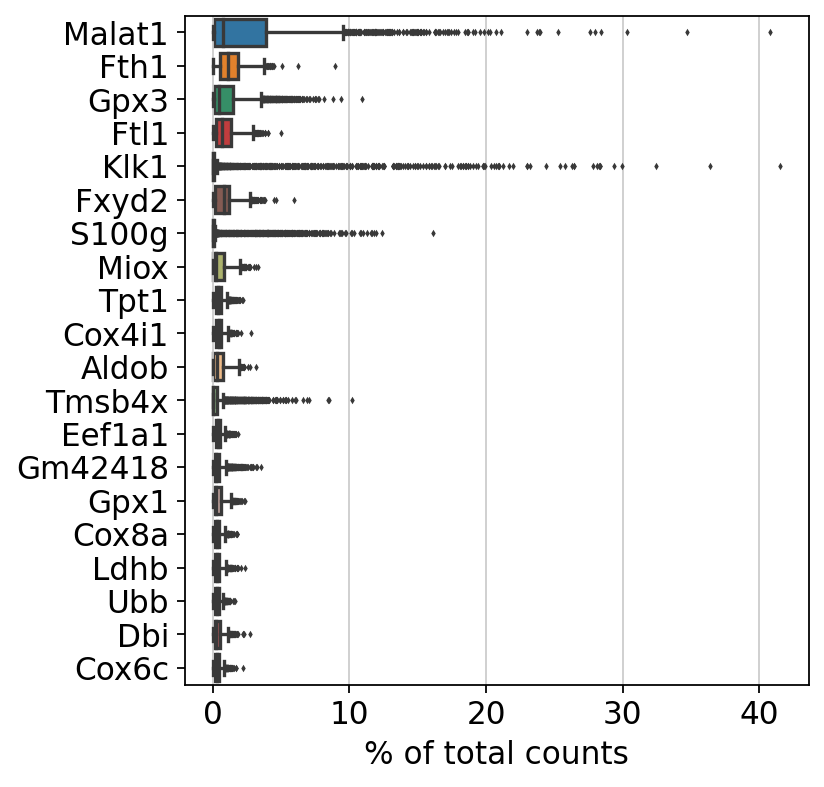

In [46]:
sc.pl.highest_expr_genes(sc_adata, n_top=20, )

In [47]:
#sc.pp.filter_cells(sc_adata, min_genes=200)
#sc.pp.filter_genes(sc_adata, min_cells=3)

In [48]:
sc_adata.var['mt'] = sc_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


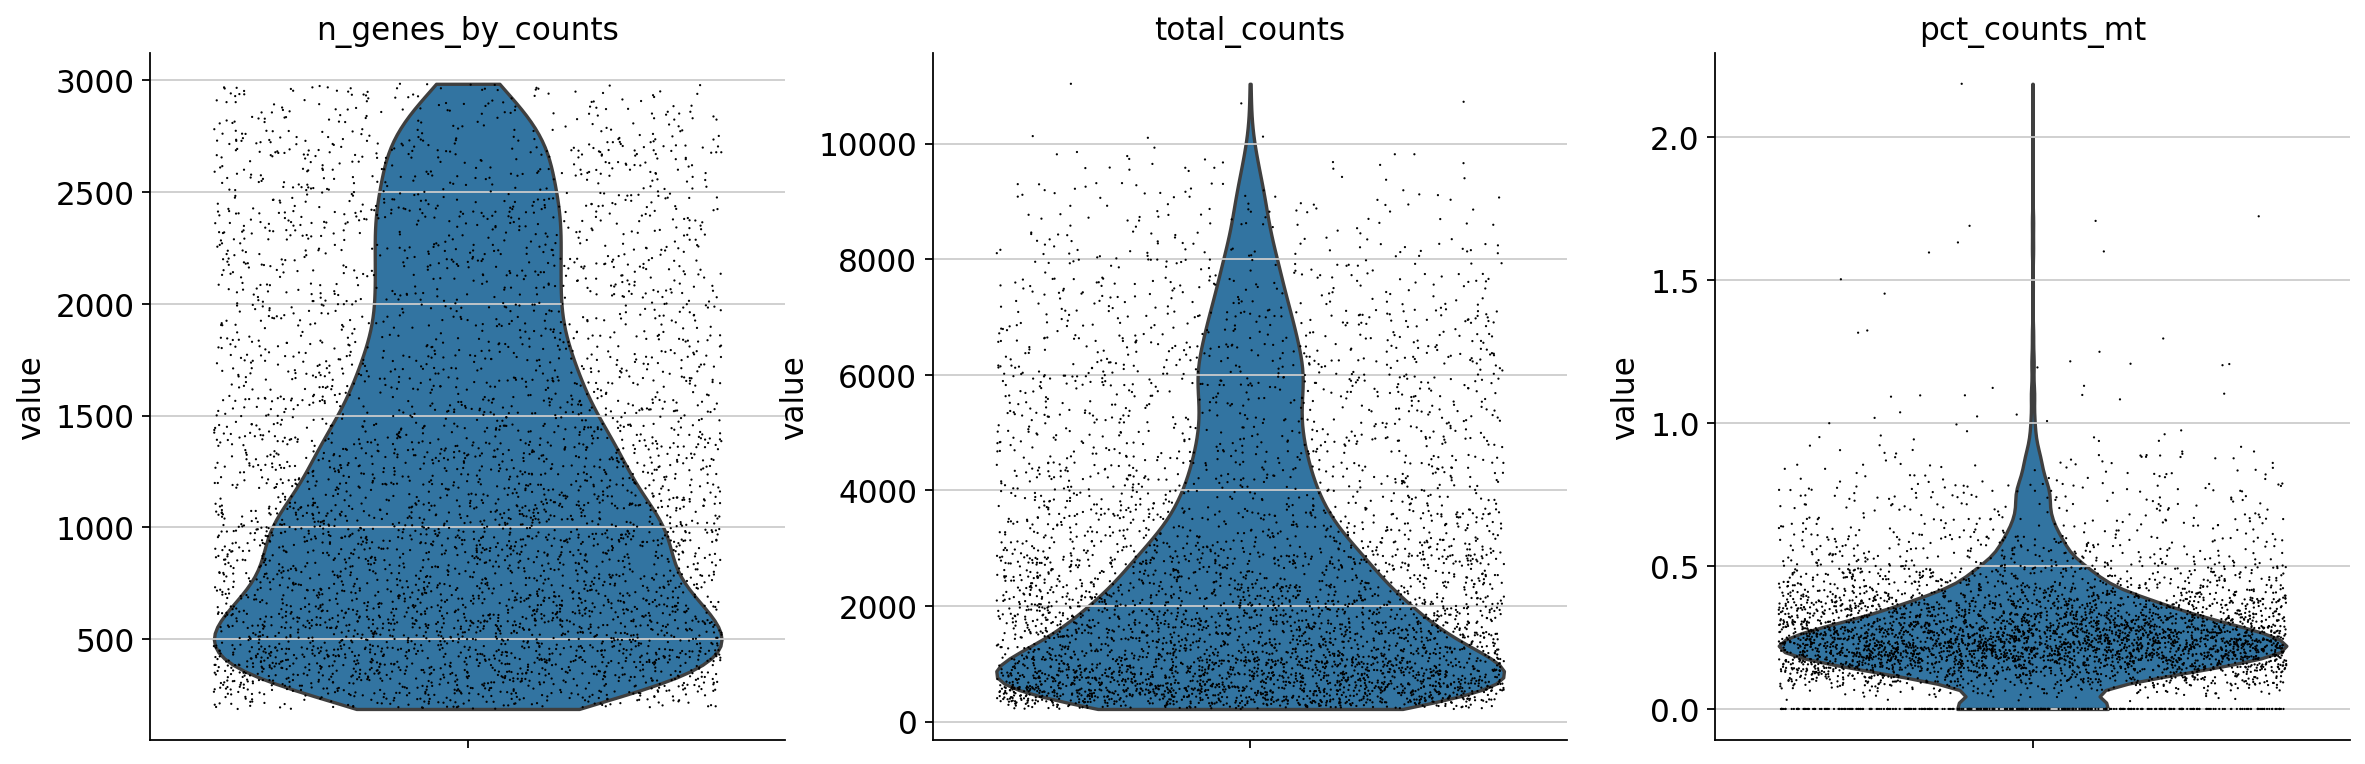

In [49]:
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

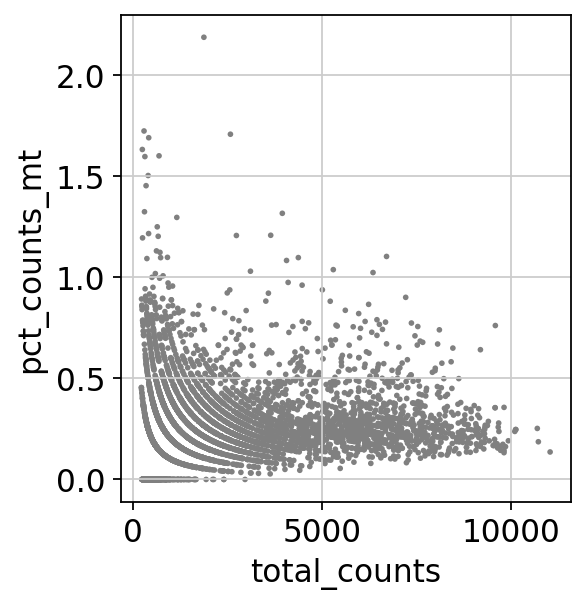

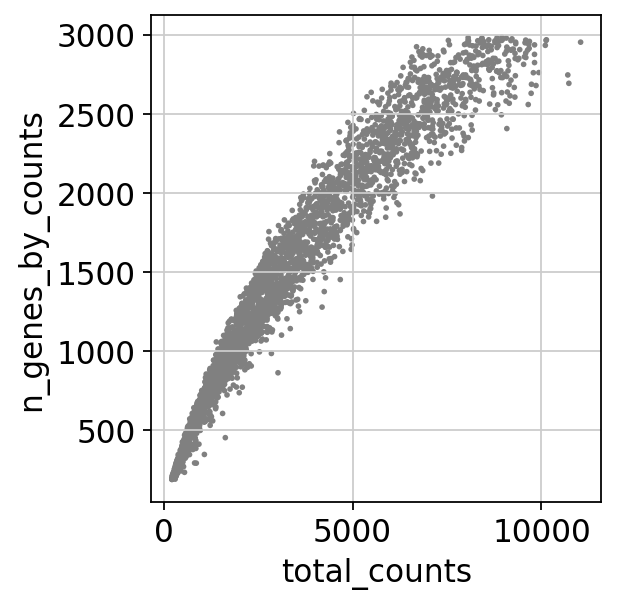

In [50]:
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sc_adata, x='total_counts', y='n_genes_by_counts')

In [51]:
#sc_data = sc_adata[sc_adata.obs.n_genes_by_counts < 10000, :]
#sc_adata = sc_adata[sc_adata.obs.pct_counts_mt < 1, :]

In [52]:
sc_adata.X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
#normalize and logarize:
#sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [54]:
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


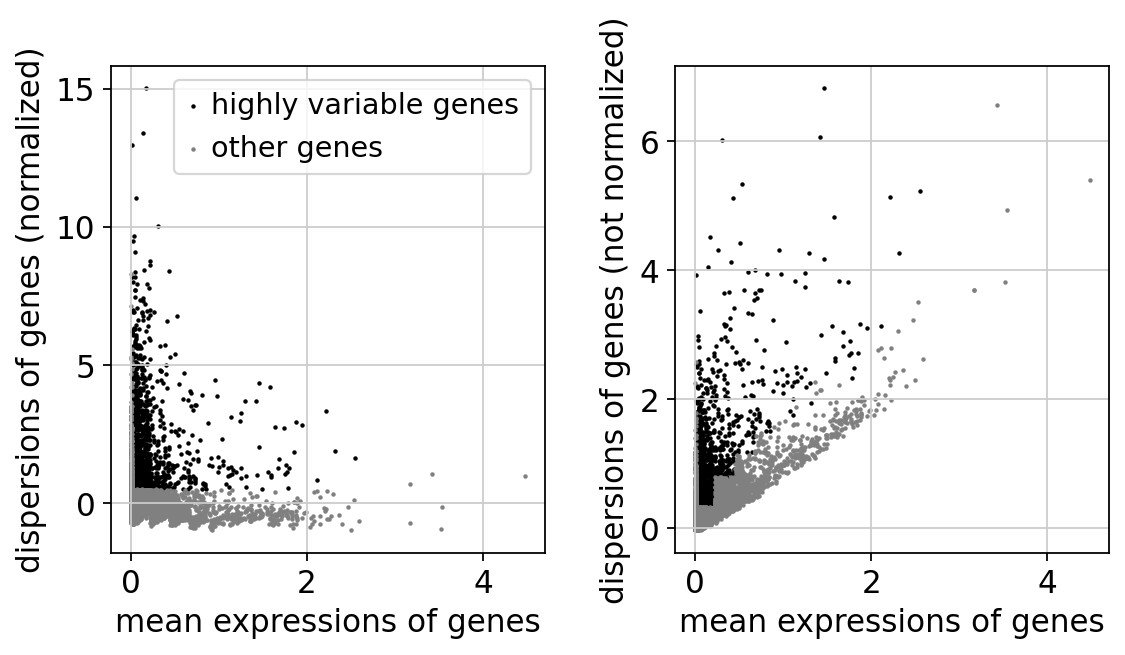

In [55]:
sc.pl.highly_variable_genes(sc_adata)

In [56]:
#sc_adata = sc_adata[:, sc_adata.var.highly_variable]
#sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])
#sc.pp.scale(sc_adata, max_value=10)

and now QCing the bulk dataset:

normalizing counts per cell
    finished (0:00:00)


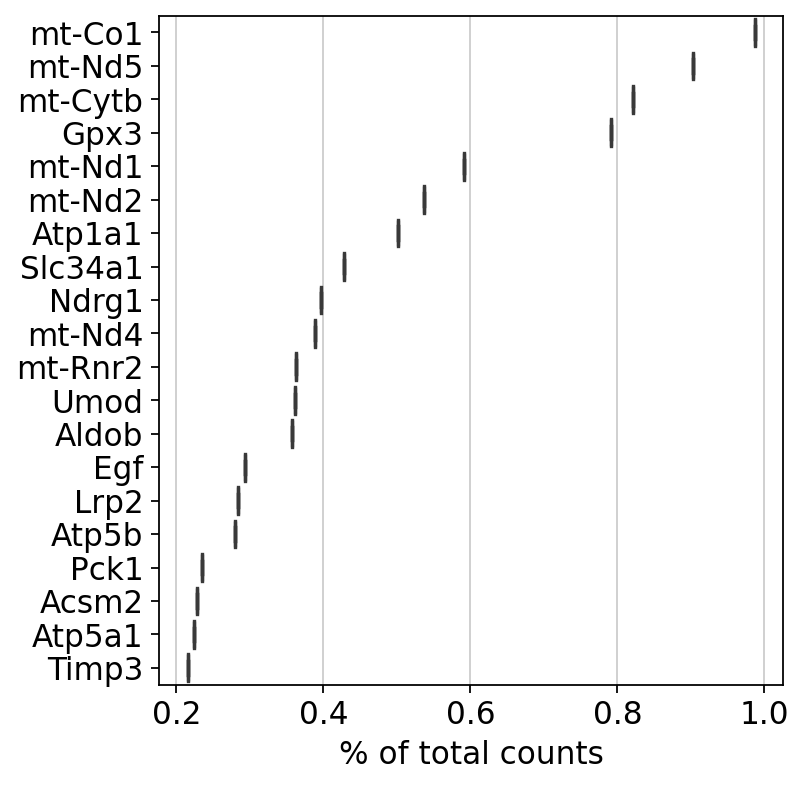

In [57]:
sc.pl.highest_expr_genes(bulk_adata, n_top=20, )

In [58]:
bulk_adata.var['mt'] = bulk_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(bulk_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

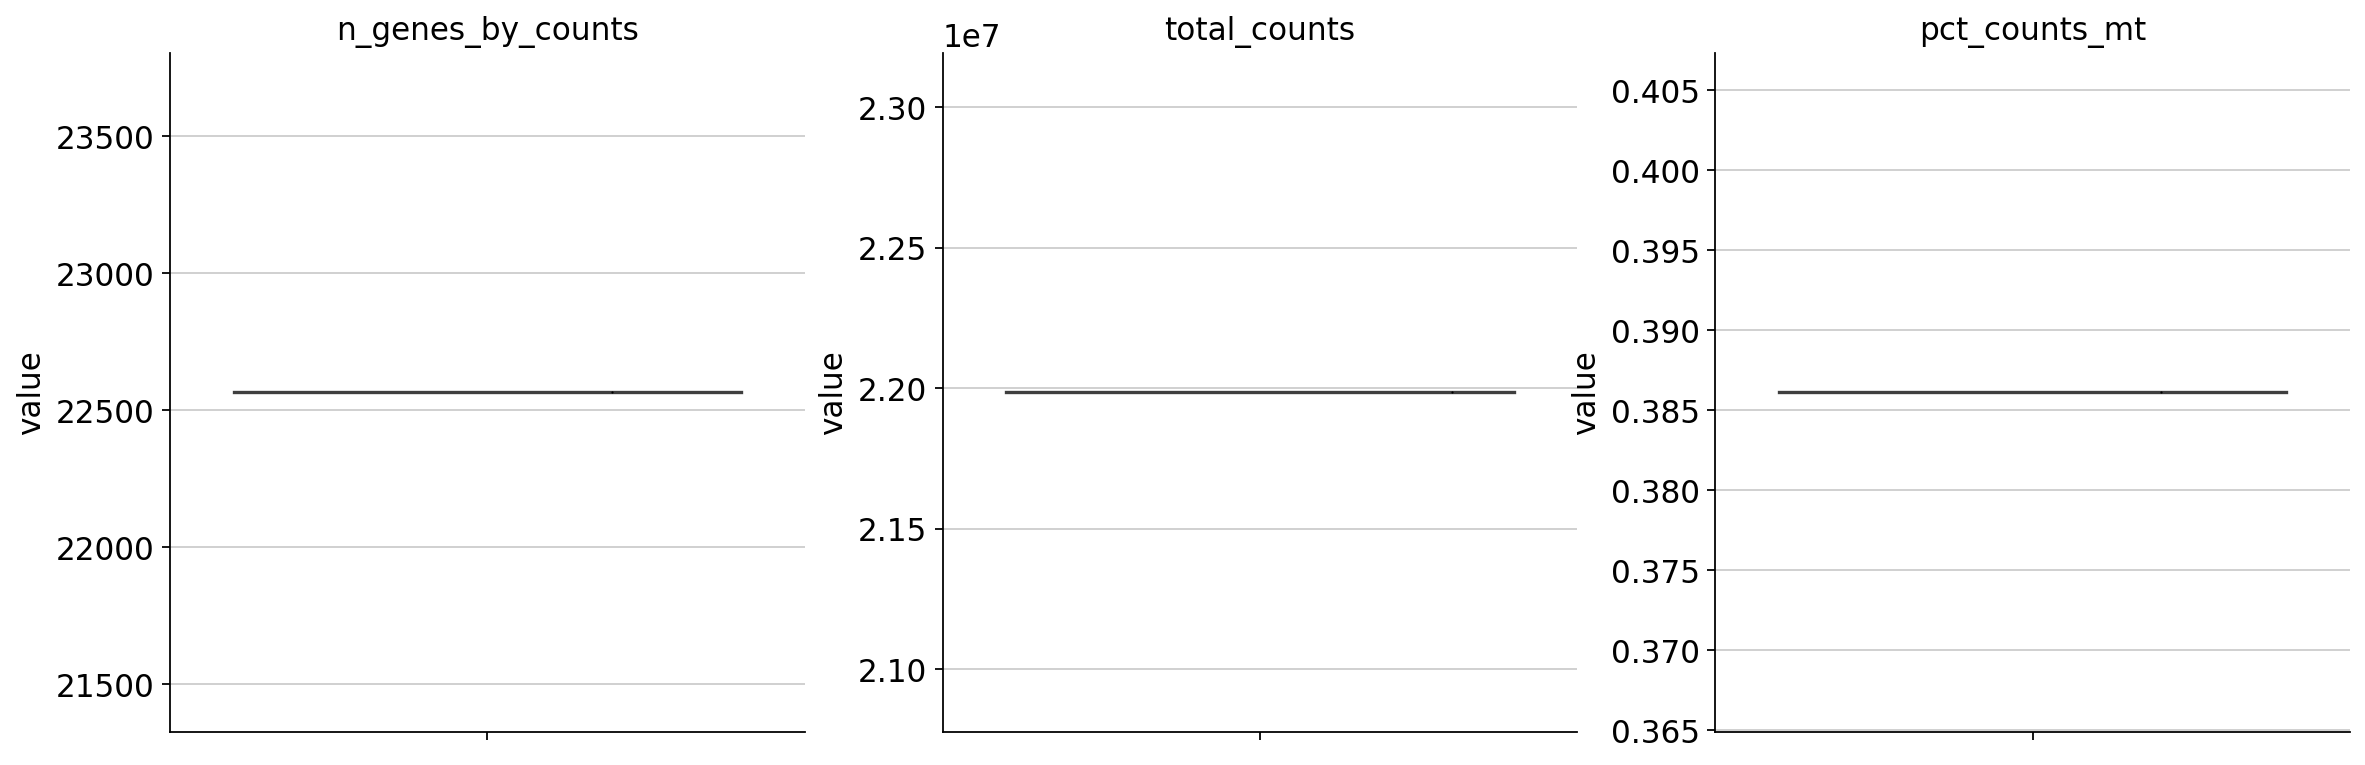

In [59]:
sc.pl.violin(bulk_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

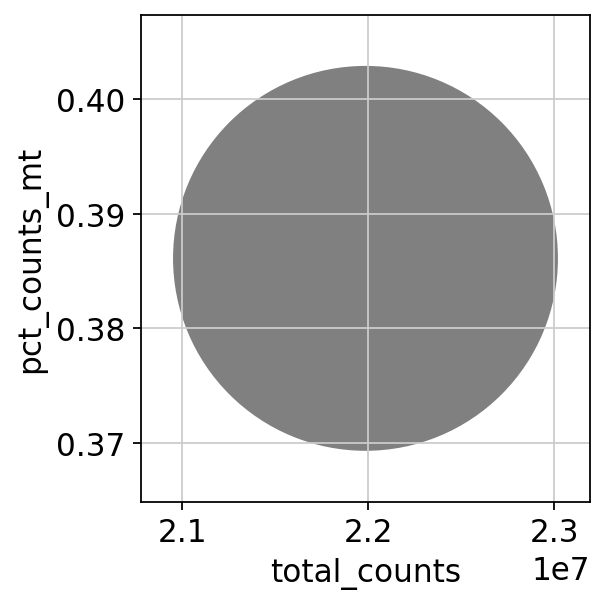

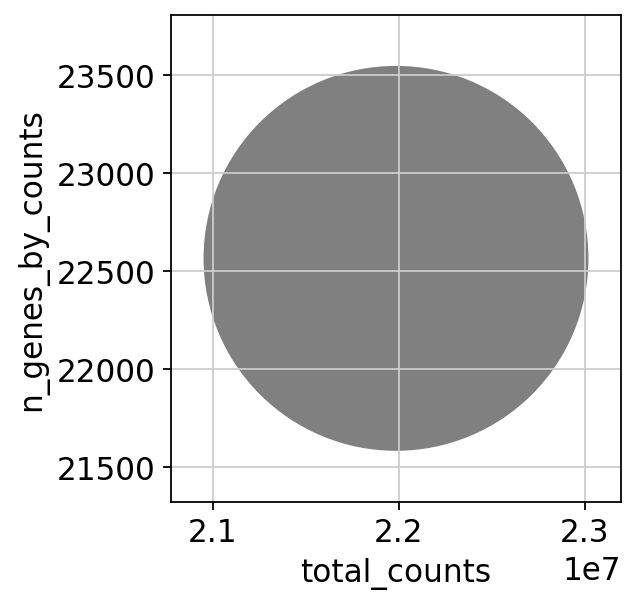

In [60]:
sc.pl.scatter(bulk_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(bulk_adata, x='total_counts', y='n_genes_by_counts')

In [61]:
#normalize and logarize:
#sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
#sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

In [62]:
#sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

Computing Clustering:

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


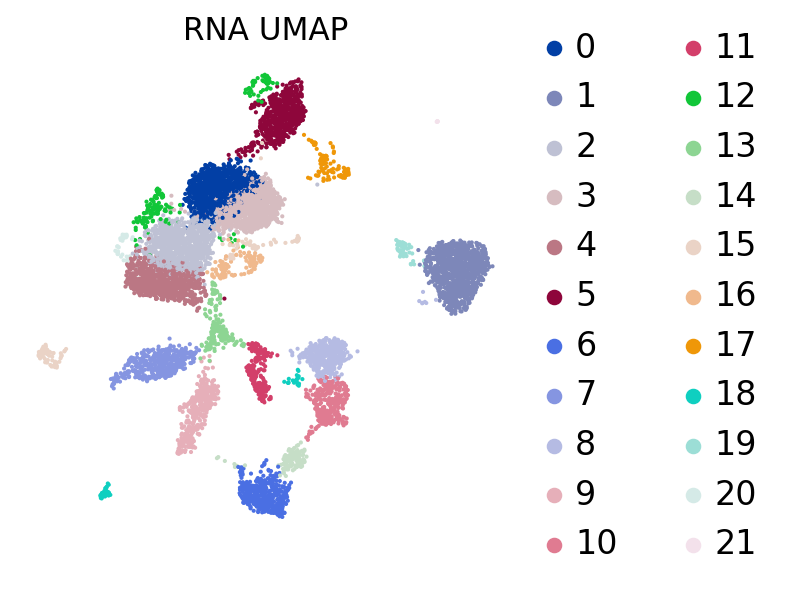

In [63]:
# Generate PCA features
sc.tl.pca(sn_adata , svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sn_adata , n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sn_adata )

# Run leiden clustering algorithm
sc.tl.leiden(sn_adata)
#sc.tl.louvain(sn_adata)

# Visualize
sc.pl.umap(sn_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


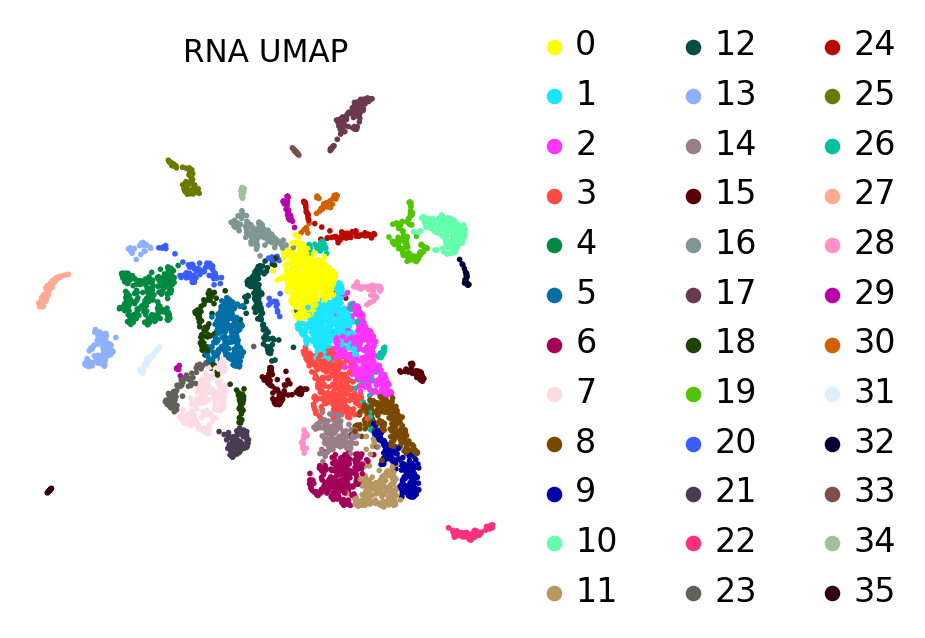

In [64]:
# Generate PCA features
sc.tl.pca(sc_adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sc_adata, n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sc_adata)

# Run leiden and louvain clustering algorithm
sc.tl.leiden(sc_adata)
#sc.tl.louvain(sc_adata)

# Visualize
sc.pl.umap(sc_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

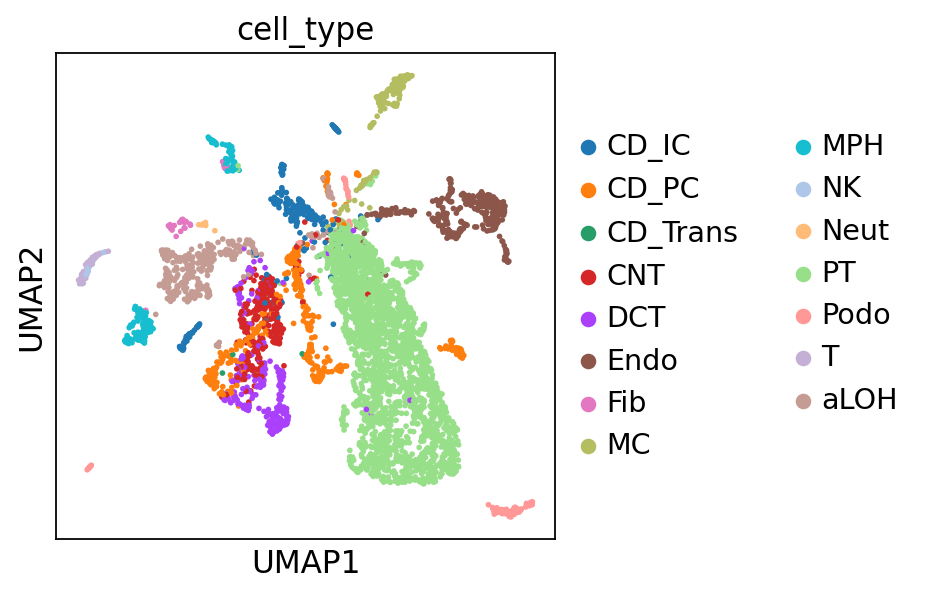

In [65]:
# Visualize cell assignments:
sc.pl.umap(sc_adata, color='cell_type')

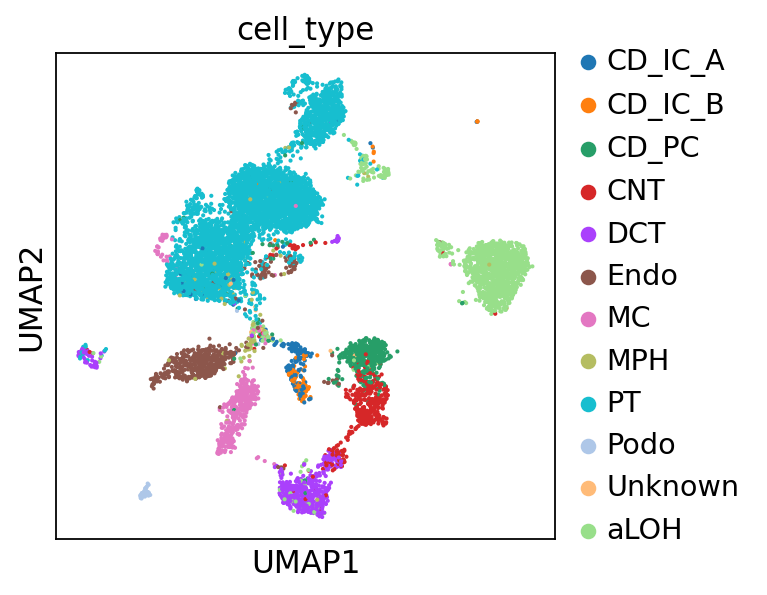

In [66]:
# Visualize cell assignments:
sc.pl.umap(sn_adata, color='cell_type')

B, B cells; 

CD-IC, collecting duct intercalated cells; 

CD-PC, collecting duct principal cells; 

CNT-CDT, connecting tubule and distal convoluted tubule cells; 

damaged PT, damaged proximal tubular cells; 

DC, dendritic cells; 

Endo, endothelial cells; 

LOH, loop of Henle cells; 

MΦ, macrophages; 

Mes, mesangial cells; 

NK, natural killer cells; 

Neutro, neutrophilic granulocytes; 

Podo, podocytes; 

PT, proximal tubular cells; 

T, T cells.


Matching cell types for comparison:

In [67]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC_A': 179,
         'MPH': 83,
         'CD_IC_B': 84,
         'Unknown': 11})

In [68]:
new_cell_names_sn = dict(aLOH = 'aLOH',
                     PT = 'PT',
                     CD_PC = 'CD_PC',
                     DCT = 'DCT', 
                     MC = 'MC',
                     CNT = 'CNT', 
                     Podo = 'Podo', 
                     Endo = 'Endo', 
                     CD_IC_A = 'CD_IC', 
                     MPH = 'MPH',
                     CD_IC_B= 'CD_IC',
                     Unknown = 'Unknown')

sn_adata.obs['cell_type'] = (
    sn_adata.obs['cell_type']
    .map(new_cell_names_sn )
    .astype('category')
)


In [69]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC': 263,
         'MPH': 83,
         'Unknown': 11})

In [70]:
Counter(sc_adata.obs['cell_type'])

Counter({'CD_IC': 220,
         'CNT': 305,
         'PT': 2319,
         'CD_PC': 375,
         'MC': 142,
         'Endo': 334,
         'DCT': 234,
         'Podo': 99,
         'aLOH': 317,
         'MPH': 159,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

In [71]:
new_cell_names_sc = dict(
         CD_IC= 'CD_IC',
         CNT = 'CNT',
         PT= 'PT',
         CD_PC = 'CD_PC',
         MC = 'MC',
         Endo = 'Endo',
         DCT= 'DCT',
         Podo = 'Podo',
         aLOH = 'aLOH',
         MPH = 'MPH',
         CD_Trans= 'CD_Trans',
         NK = 'NK',
         Fib = 'Fib',
         T = 'T',
         Neut = 'Neut')

sc_adata.obs['cell_type'] = (
    sc_adata.obs['cell_type']
    .map(new_cell_names_sc )
    .astype('category')
)


In [72]:
sn_props = make_prop_table(sn_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ aLOH         │        1253 │   0.145512   │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ PT           │        4671 │   0.542446   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ CD_PC        │         433 │   0.0502845  │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ DCT          │         528 │   0.0613169  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         403 │   0.0468006  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ CNT          │         396 │   0.0459877  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ Podo         │          46 │   0.005342   │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Endo         │         524 │   0.0608524  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ CD_IC        │         2

In [73]:
sc_props = make_prop_table(sc_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ CD_IC        │         220 │   0.0477638  │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ CNT          │         305 │   0.066218   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ PT           │        2319 │   0.503474   │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ CD_PC        │         375 │   0.0814155  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         142 │   0.0308294  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ Endo         │         334 │   0.0725141  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ DCT          │         234 │   0.0508033  │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Podo         │          99 │   0.0214937  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ aLOH         │         3

In [74]:
sn_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
8       CD_IC        263    0.030542
2       CD_PC        433    0.050285
5         CNT        396    0.045988
3         DCT        528    0.061317
7        Endo        524    0.060852
4          MC        403    0.046801
9         MPH         83    0.009639
1          PT       4671    0.542446
6        Podo         46    0.005342
11      Total       8611    1.000000
10    Unknown         11    0.001277
0        aLOH       1253    0.145512

In [75]:
sc_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
0       CD_IC        220    0.047764
3       CD_PC        375    0.081416
10   CD_Trans          5    0.001086
1         CNT        305    0.066218
6         DCT        234    0.050803
5        Endo        334    0.072514
12        Fib         33    0.007165
4          MC        142    0.030829
9         MPH        159    0.034520
11         NK         11    0.002388
14       Neut          7    0.001520
2          PT       2319    0.503474
7        Podo         99    0.021494
13          T         46    0.009987
15      Total       4606    1.000000
8        aLOH        317    0.068823

To compare, we're mergint the satasets together, but keeping origin as an obs.

In [76]:
sn_adata.obs['orig'] = 'single_nucleus'
together_sn = list()
counter_sn = 0
for value in sn_adata.obs['orig']:
    together_sn.append(f"{value}_{sn_adata.obs['cell_type'][counter_sn]}")
    counter_sn = counter_sn+1
together_sn   

['single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_CD_PC',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_MC',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_CNT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Podo',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLO

In [77]:
sn_adata.obs['orig_and_celltype'] = together_sn

In [78]:
sc_adata.obs['orig'] = 'single_cell'
together_sc = list()
counter_sc = 0
for value in sc_adata.obs['orig']:
    together_sc.append(f"{value}_{sc_adata.obs['cell_type'][counter_sc]}")
    counter_sc = counter_sc+1
together_sc   

['single_cell_CD_IC',
 'single_cell_CD_IC',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_IC',
 'single_cell_PT',
 'single_cell_MC',
 'single_cell_CNT',
 'single_cell_Endo',
 'single_cell_DCT',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_aLOH',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_DCT',
 'single_cell_MC',
 'single_cell_MPH',
 'single_cell_CD_IC',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cel

In [79]:
sc_adata.obs['orig_and_celltype'] = together_sc

In [80]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_inner = sn_adata.concatenate(sc_adata, join='inner')
single_adata_inner

AnnData object with n_obs × n_vars = 13217 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'batch'
    var: 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'

In [81]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_outer = sn_adata.concatenate(sc_adata, join='outer')
single_adata_outer

AnnData object with n_obs × n_vars = 13217 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'batch'
    var: 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'

In [82]:
Counter(single_adata_inner.obs['cell_type'])

Counter({'aLOH': 1570,
         'PT': 6990,
         'CD_PC': 808,
         'DCT': 762,
         'MC': 545,
         'CNT': 701,
         'Podo': 145,
         'Endo': 858,
         'CD_IC': 483,
         'MPH': 242,
         'Unknown': 11,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

Computing average gene expression per cell type and origin:

In [83]:
single_adata_inner.obs['orig_and_celltype'] =  single_adata_inner.obs['orig_and_celltype'].astype('category')

In [84]:
####Code altered from : https://scanpy.discourse.group/t/how-to-calculate-the-average-gene-expression-within-each-cluster/126/2
res_inner = pd.DataFrame(columns=single_adata_inner.var_names, index=single_adata_inner.obs['orig_and_celltype'].cat.categories) 
for clust in single_adata_inner.obs.orig_and_celltype.cat.categories: 
    res_inner.loc[clust] = single_adata_inner[single_adata_inner.obs['orig_and_celltype'].isin([clust]),:].X.mean(0)
#reordering columsn so they match    
res_inner = res_inner.reindex(sorted(res_inner.columns), axis=1)
res_inner  #res inner now contains the mean expression per gene of each cell type

0610007P14Rik 0610009B22Rik 0610009L18Rik  \
single_cell_CD_IC           0.074308      0.177508      0.022055   
single_cell_CD_PC           0.153906      0.188119      0.073483   
single_cell_CD_Trans             0.0      0.138629      0.138629   
single_cell_CNT             0.034475       0.16423      0.046782   
single_cell_DCT             0.115302      0.312595      0.080985   
single_cell_Endo            0.084578      0.085792      0.006226   
single_cell_Fib             0.204896      0.042009           0.0   
single_cell_MC              0.080956      0.194886      0.083812   
single_cell_MPH             0.050504      0.039235      0.008719   
single_cell_NK              0.126027           0.0           0.0   
single_cell_Neut                 0.0           0.0           0.0   
single_cell_PT               0.10303      0.198253      0.040306   
single_cell_Podo            0.070015      0.155222      0.109118   
single_cell_T               0.120547      0.030137      0.015068   
single_cell_aLOH            0.120098      0.235122      0.062875   
single_nucleus_CD_IC        0.052711      0.013178      0.007907   
single_nucleus_CD_PC        0.016008      0.011206      0.014407   
single_nucleus_CNT          0.019254      0.014003      0.003501   
single_nucleus_DCT          0.011815       0.01127      0.006564   
single_nucleus_Endo         0.019842      0.024584      0.003968   
single_nucleus_MC           0.027519       0.01548       0.00688   
single_nucleus_MPH               0.0           0.0      0.008351   
single_nucleus_PT           0.028777       0.02764      0.008013   
single_nucleus_Podo              0.0      0.045205      0.015068   
single_nucleus_Unknown      0.063013           0.0           0.0   
single_nucleus_aLOH         0.023746      0.010511      0.006638   

                       0610009O20Rik 0610010F05Rik 0610010K14Rik  \
single_cell_CD_IC           0.053561      0.015753      0.022055   
single_cell_CD_PC           0.066542      0.029888      0.053917   
single_cell_CD_Trans        0.277259           0.0           0.0   
single_cell_CNT             0.028601      0.029544      0.028601   
single_cell_DCT             0.089872      0.031354      0.080985   
single_cell_Endo            0.067976      0.026117      0.095816   
single_cell_Fib             0.063013      0.042009      0.063013   
single_cell_MC              0.053695      0.009763      0.048813   
single_cell_MPH                  0.0      0.008719      0.026156   
single_cell_NK                   0.0           0.0      0.063013   
single_cell_Neut                 0.0           0.0           0.0   
single_cell_PT              0.033505      0.027527      0.046933   
single_cell_Podo            0.098021      0.028006      0.042009   
single_cell_T                    0.0           0.0      0.135616   
single_cell_aLOH            0.106607      0.028426      0.059409   
single_nucleus_CD_IC         0.03471      0.018449           0.0   
single_nucleus_CD_PC         0.01921      0.023348           0.0   
single_nucleus_CNT          0.019254      0.012253           0.0   
single_nucleus_DCT          0.032275      0.015753           0.0   
single_nucleus_Endo         0.025907      0.011905           0.0   
single_nucleus_MC           0.023366       0.01892           0.0   
single_nucleus_MPH          0.041756      0.016702           0.0   
single_nucleus_PT           0.025017      0.016461           0.0   
single_nucleus_Podo              0.0      0.015068           0.0   
single_nucleus_Unknown           0.0           0.0           0.0   
single_nucleus_aLOH         0.021021      0.016596           0.0   

                       0610011F06Rik 0610012G03Rik 0610025J13Rik  \
single_cell_CD_IC           0.274649      0.359907           0.0   
single_cell_CD_PC            0.38898      0.499749           0.0   
single_cell_CD_Trans        0.138629      0.578074           0.0   
single_cell_CNT             0.237729      0.350977           0.0   
single_ce

Comparing average gene expression per cell type in sn vs. sc:

In [85]:
#First extracting cells that are matching and non-matching
matching_celltypes = list(['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
nonmatching_celltypes = list(['CD_Trans', 'NK', 'Fib', 'Unknown'])
len(matching_celltypes)

10

In [86]:
#Creating dataframes to append average data
av_df = pd.DataFrame(columns=["SN", "SC"], index=res_inner.columns)
av_df_celltype = pd.DataFrame(columns=single_adata_inner.obs['orig_and_celltype'], index=res_inner.columns)

mse_df = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
mse_df_snbulk  = pd.DataFrame(columns=res_inner.columns)
mse_df_scbulk  = pd.DataFrame(columns=res_inner.columns)

pear_df_snsc = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
pear_df_snbulk = pd.DataFrame(columns=res_inner.columns)
pear_df_scbulk = pd.DataFrame(columns=res_inner.columns)

In [87]:
res_inner

0610007P14Rik 0610009B22Rik 0610009L18Rik  \
single_cell_CD_IC           0.074308      0.177508      0.022055   
single_cell_CD_PC           0.153906      0.188119      0.073483   
single_cell_CD_Trans             0.0      0.138629      0.138629   
single_cell_CNT             0.034475       0.16423      0.046782   
single_cell_DCT             0.115302      0.312595      0.080985   
single_cell_Endo            0.084578      0.085792      0.006226   
single_cell_Fib             0.204896      0.042009           0.0   
single_cell_MC              0.080956      0.194886      0.083812   
single_cell_MPH             0.050504      0.039235      0.008719   
single_cell_NK              0.126027           0.0           0.0   
single_cell_Neut                 0.0           0.0           0.0   
single_cell_PT               0.10303      0.198253      0.040306   
single_cell_Podo            0.070015      0.155222      0.109118   
single_cell_T               0.120547      0.030137      0.015068   
single_cell_aLOH            0.120098      0.235122      0.062875   
single_nucleus_CD_IC        0.052711      0.013178      0.007907   
single_nucleus_CD_PC        0.016008      0.011206      0.014407   
single_nucleus_CNT          0.019254      0.014003      0.003501   
single_nucleus_DCT          0.011815       0.01127      0.006564   
single_nucleus_Endo         0.019842      0.024584      0.003968   
single_nucleus_MC           0.027519       0.01548       0.00688   
single_nucleus_MPH               0.0           0.0      0.008351   
single_nucleus_PT           0.028777       0.02764      0.008013   
single_nucleus_Podo              0.0      0.045205      0.015068   
single_nucleus_Unknown      0.063013           0.0           0.0   
single_nucleus_aLOH         0.023746      0.010511      0.006638   

                       0610009O20Rik 0610010F05Rik 0610010K14Rik  \
single_cell_CD_IC           0.053561      0.015753      0.022055   
single_cell_CD_PC           0.066542      0.029888      0.053917   
single_cell_CD_Trans        0.277259           0.0           0.0   
single_cell_CNT             0.028601      0.029544      0.028601   
single_cell_DCT             0.089872      0.031354      0.080985   
single_cell_Endo            0.067976      0.026117      0.095816   
single_cell_Fib             0.063013      0.042009      0.063013   
single_cell_MC              0.053695      0.009763      0.048813   
single_cell_MPH                  0.0      0.008719      0.026156   
single_cell_NK                   0.0           0.0      0.063013   
single_cell_Neut                 0.0           0.0           0.0   
single_cell_PT              0.033505      0.027527      0.046933   
single_cell_Podo            0.098021      0.028006      0.042009   
single_cell_T                    0.0           0.0      0.135616   
single_cell_aLOH            0.106607      0.028426      0.059409   
single_nucleus_CD_IC         0.03471      0.018449           0.0   
single_nucleus_CD_PC         0.01921      0.023348           0.0   
single_nucleus_CNT          0.019254      0.012253           0.0   
single_nucleus_DCT          0.032275      0.015753           0.0   
single_nucleus_Endo         0.025907      0.011905           0.0   
single_nucleus_MC           0.023366       0.01892           0.0   
single_nucleus_MPH          0.041756      0.016702           0.0   
single_nucleus_PT           0.025017      0.016461           0.0   
single_nucleus_Podo              0.0      0.015068           0.0   
single_nucleus_Unknown           0.0           0.0           0.0   
single_nucleus_aLOH         0.021021      0.016596           0.0   

                       0610011F06Rik 0610012G03Rik 0610025J13Rik  \
single_cell_CD_IC           0.274649      0.359907           0.0   
single_cell_CD_PC            0.38898      0.499749           0.0   
single_cell_CD_Trans        0.138629      0.578074           0.0   
single_cell_CNT             0.237729      0.350977           0.0   
single_ce

In [89]:
for gene in res_inner.columns:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        av_df["SC"][gene] = res_inner.loc[f"single_cell_{cell}"][gene]
        av_df["SN"][gene] = res_inner.loc[f"single_nucleus_{cell}"][gene]
av_df

SN        SC
0610007P14Rik  0.023746  0.120098
0610009B22Rik  0.010511  0.235122
0610009L18Rik  0.006638  0.062875
0610009O20Rik  0.021021  0.106607
0610010F05Rik  0.016596  0.028426
...                 ...       ...
Zyg11b         0.033609  0.087671
Zyx            0.006638  0.032799
Zzef1          0.060256  0.088207
Zzz3            0.04555  0.080368
l7Rn6          0.021898  0.179879

[13707 rows x 2 columns]

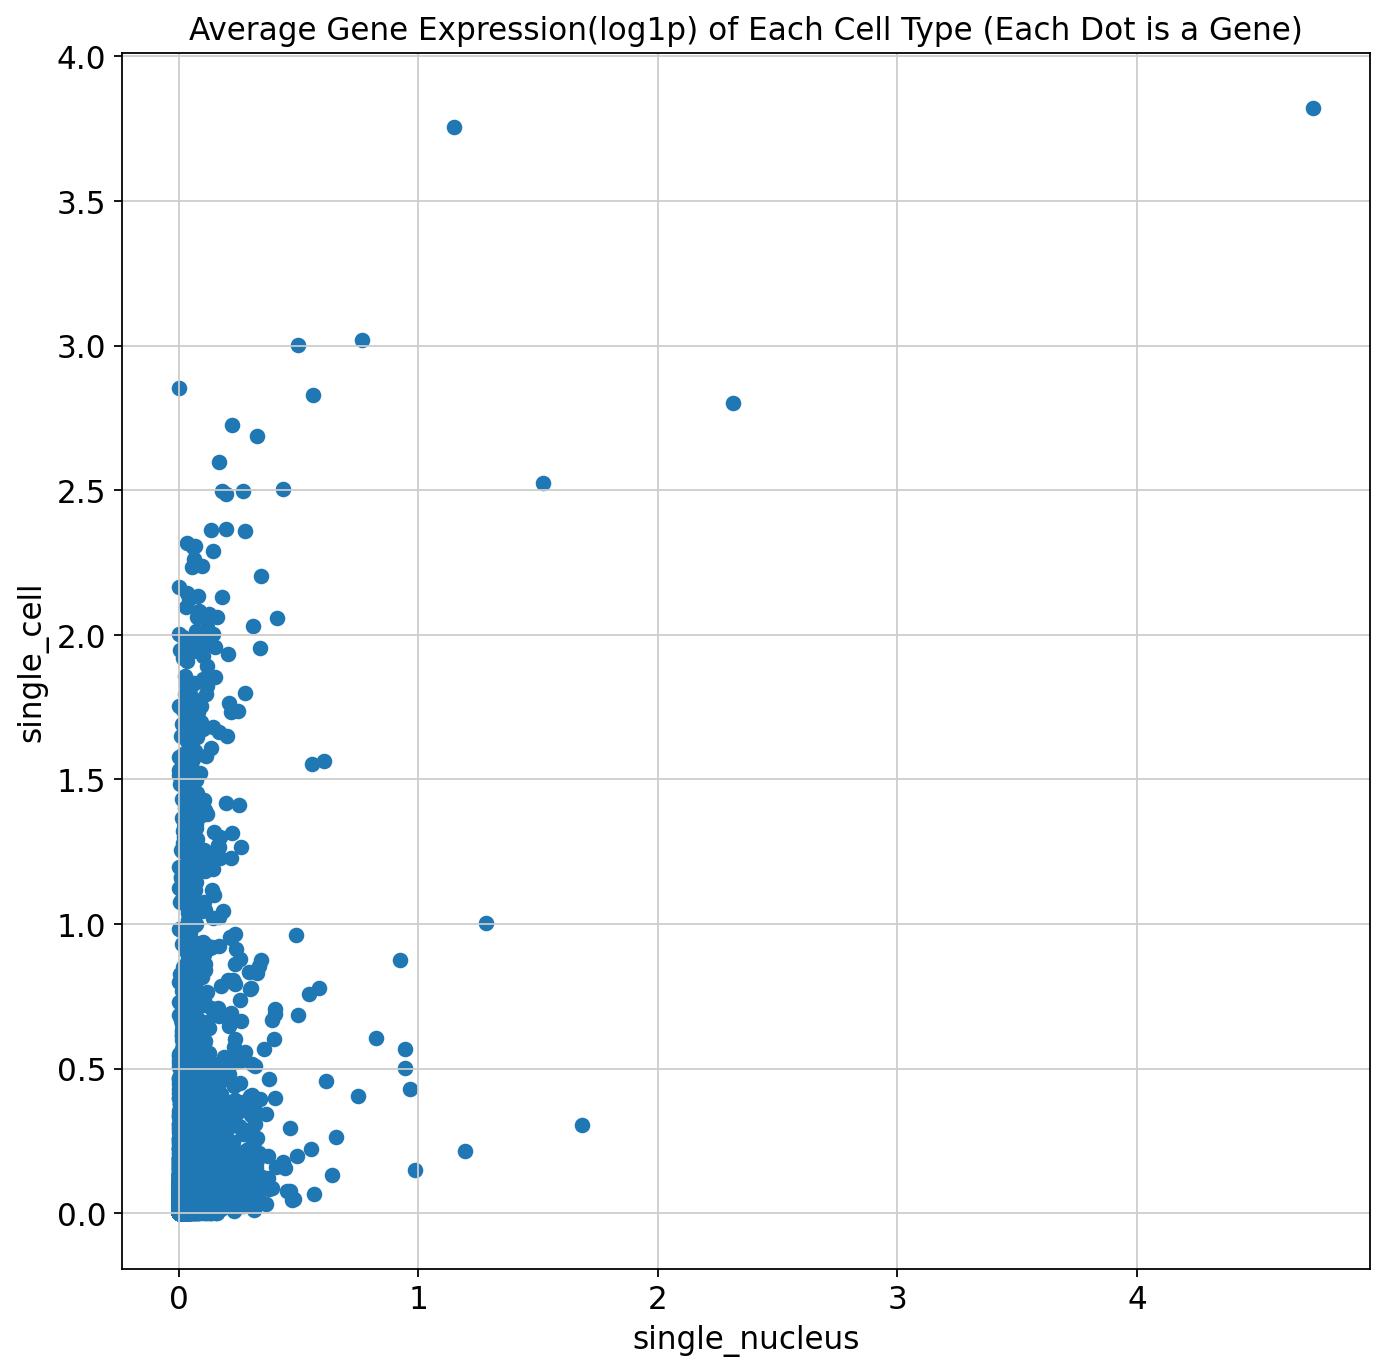

In [90]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df["SN"], y = av_df["SC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(log1p) of Each Cell Type (Each Dot is a Gene)")
plt.show()

In [91]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [92]:
single_df = pd.DataFrame(single_adata_inner.X, columns = single_adata_inner.var_names, index = single_adata_inner.obs['orig_and_celltype'])
single_df

Sox17    Mrpl15    Lypla1     Tcea1   Atp6v1h  Rb1cc1  \
orig_and_celltype                                                            
single_nucleus_aLOH    0.0  0.000000  0.000000  0.000000  0.000000     0.0   
single_nucleus_aLOH    0.0  0.000000  0.000000  0.000000  0.000000     0.0   
single_nucleus_aLOH    0.0  0.000000  0.000000  0.000000  0.000000     0.0   
single_nucleus_PT      0.0  0.000000  0.000000  0.000000  0.000000     0.0   
single_nucleus_aLOH    0.0  0.000000  0.000000  0.000000  0.693147     0.0   
...                    ...       ...       ...       ...       ...     ...   
single_cell_PT         0.0  0.693147  0.693147  0.000000  0.000000     0.0   
single_cell_CNT        0.0  0.000000  0.000000  0.693147  0.693147     0.0   
single_cell_aLOH       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
single_cell_Endo       0.0  0.000000  0.693147  0.000000  0.000000     0.0   
single_cell_PT         0.0  0.000000  0.000000  0.000000  0.000000     0.0   

                     4732440D04Rik    Pcmtd1  Rrs1  Adhfe1  ...  Med9os  \
orig_and_celltype                                           ...           
single_nucleus_aLOH            0.0  0.000000   0.0     0.0  ...     0.0   
single_nucleus_aLOH            0.0  0.000000   0.0     0.0  ...     0.0   
single_nucleus_aLOH            0.0  0.000000   0.0     0.0  ...     0.0   
single_nucleus_PT              0.0  0.000000   0.0     0.0  ...     0.0   
single_nucleus_aLOH            0.0  0.000000   0.0     0.0  ...     0.0   
...                            ...       ...   ...     ...  ...     ...   
single_cell_PT                 0.0  0.693147   0.0     0.0  ...     0.0   
single_cell_CNT                0.0  0.000000   0.0     0.0  ...     0.0   
single_cell_aLOH               0.0  0.000000   0.0     0.0  ...     0.0   
single_cell_Endo               0.0  0.000000   0.0     0.0  ...     0.0   
single_cell_PT                 0.0  0.000000   0.0     0.0  ...     0.0   

                     Cyb5d1  Camkk1  Hmga1-rs1  Dscc1  Apol9a  Apol7c  Apol9b  \
orig_and_celltype                                                               
single_nucleus_aLOH     0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_nucleus_aLOH     0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_nucleus_aLOH     0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_nucleus_PT       0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_nucleus_aLOH     0.0     0.0        0.0    0.0     0.0     0.0     0.0   
...                     ...     ...        ...    ...     ...     ...     ...   
single_cell_PT          0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_cell_CNT         0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_cell_aLOH        0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_cell_Endo        0.0     0.0        0.0    0.0     0.0     0.0     0.0   
single_cell_PT          0.0     0.0        0.0    0.0     0.0     0.0     0.0   

                     Btla  Csprs  
orig_and_celltype                 
single_nucleus_aLOH   0.0    0.0  
single_nucleus_aLOH   0.0    0.0  
single_nucleus_aLOH   0.0    0.0  
single_nucleus_PT     0.0    0.0  
single_nucleus_aLOH   0.0    0.0  
...                   ...    ...  
single_cell_PT        0.0    0.0  
single_cell_CNT       0.0    0.0  
single_cell_aLOH      0.0    0.0  
single_cell_Endo      0.0    0.0  
single_cell_PT        0.0    0.0  

[13217 rows x 13707 columns]

In [93]:
# #Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
# for gene in single_df.columns:
#     for cell in matching_celltypes:
#         #mean of all the expression of celltype in gene in sc and sn
#         sc_val = np.mean(single_df.loc[f"single_cell_{cell}"][gene])
#         sn_val = np.mean(single_df.loc[f"single_nucleus_{cell}"][gene])
#         #adding mse to another dataframe
#         mse_df.loc[cell][gene] = mean_sqr_error(sc_val, sn_val)
# mse_df

In [94]:
# mse_df = mse_df.astype('float')
# mse_df = mse_df.transpose()

In [95]:
# #Saving mse df
# pickle.dump(mse_df, open( f"{processed_path}mse_snsc_df_notscaled.pkl", "wb" ) 
mse_df = pickle.load( open( f"{processed_path}mse_snsc_df_notscaled.pkl", "rb" ) )

Text(0.5, 1.0, 'MSE of Average SN vs. Average SC per Common Gene')

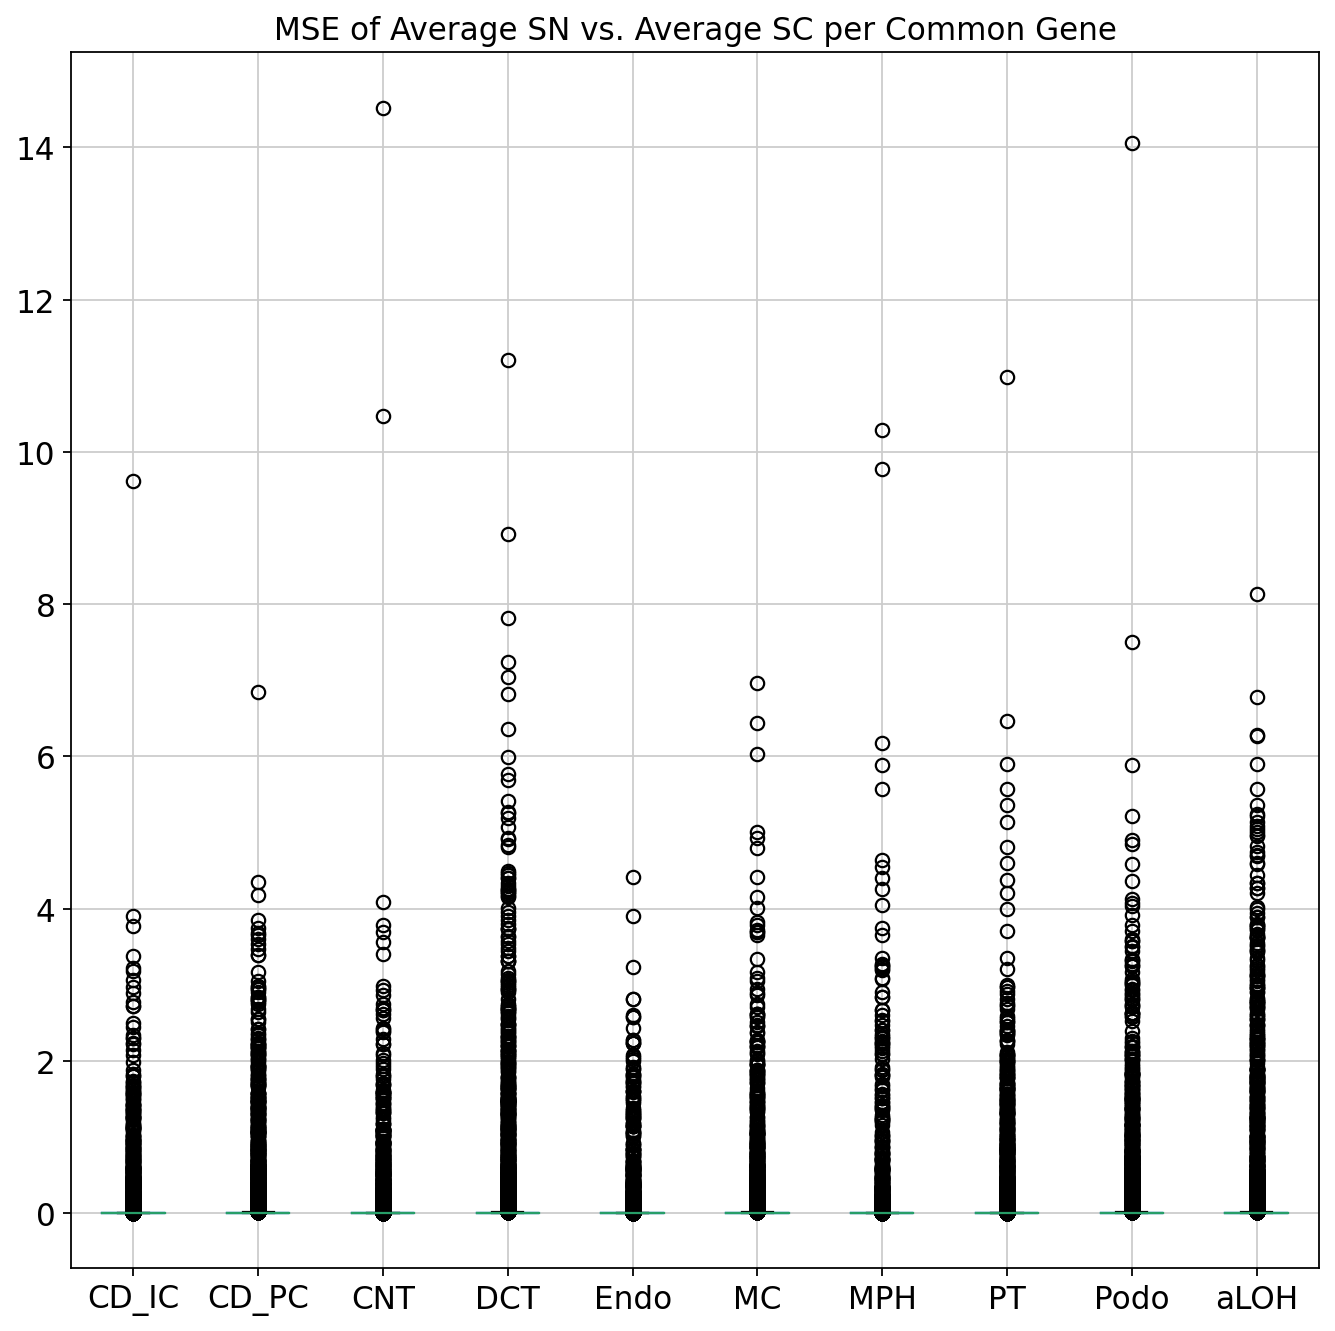

In [96]:
plt.figure(figsize= [10,10])
mse_df.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
plt.title('MSE of Average SN vs. Average SC per Common Gene')

In [99]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in single_adata_inner.var:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        sc_val = np.mean(single_adata_inner[single_adata_inner.obs["orig_and_celltype"]==f"single_cell_{cell}"])
        sn_val = np.mean(single_adata_inner[single_adata_inner.obs["orig_and_celltype"]==f"single_nucleus_{cell}"])
        #adding mse to another dataframe
        pear_df_snsc[cell] = pearsonr(sc_val, sn_val)[0]       
pear_df_snsc

In [ ]:
pear_df_snsc= pear_df_snsc.astype('float')
pear_df_snsc = pear_df_snsc.transpose()

In [ ]:
plt.figure(figsize= [10,10])
pear_df_snsc.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
plt.title('Pearson of Average SN vs. Average SC per Common Gene (log1p)')

Tryign linear regression model with the first cell type:

In [ ]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the bulk data to contain only genes available in common_genes SN and SC
common_gene_indicator_bulk = np.in1d(bulk_adata.var_names, common_genes_wbulk)
bulk_adata = bulk_adata[:, common_gene_indicator_bulk]
bulk_adata

View of AnnData object with n_obs × n_vars = 1 × 13686
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var_names)
#reordering columsn so they match    
bulk_adata_df= bulk_adata_df.reindex(sorted(bulk_adata_df.columns), axis=1)
bulk_adata_df

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
0       6.539586       6.411819       4.094345       7.467371       6.084499   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
0       3.850148        8.11552       7.056175       2.833213       7.049255   

   ...    Zufsp      Zw10     Zwint      Zxdb      Zxdc    Zyg11b       Zyx  \
0  ...  5.47227  6.375025  7.500529  5.036952  6.526495  7.653495  7.010312   

      Zzef1      Zzz3     l7Rn6  
0  7.540091  7.254885  6.251904  

[1 rows x 13686 columns]

In [ ]:
#trimming down the sn and sc data  to contain only genes available in bulk as well.
sn_adata = sn_adata[:, common_genes_wbulk]
sc_adata = sc_adata[:, common_genes_wbulk]

In [ ]:
av_per_gene_sn = pd.DataFrame(columns=sn_adata.var_names, index = [1])
av_per_gene_sc = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
for gene in sn_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_nucleus_{cell}"][gene] 
    av_per_gene_sn[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sn    

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1       0.019967       0.017308        0.00813       0.024251       0.016545   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1            0.0            0.0       0.039726       0.000902       0.035526   

   ...     Zufsp      Zw10     Zwint    Zxdb      Zxdc   Zyg11b       Zyx  \
1  ...  0.016692  0.010723  0.032587  0.0052  0.013463  0.03294  0.013916   

      Zzef1      Zzz3     l7Rn6  
1  0.089453  0.054176  0.015984  

[1 rows x 13686 columns]

In [ ]:
for gene in sc_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_cell_{cell}"][gene] 
    av_per_gene_sc[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sc   

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1       0.088717       0.175096       0.053436       0.059838        0.02351   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1        0.05047       0.315984       0.424381       0.003925       0.080191   

   ...     Zufsp     Zw10    Zwint      Zxdb      Zxdc    Zyg11b       Zyx  \
1  ...  0.022786  0.01413  0.08856  0.017342  0.026513  0.062907  0.050906   

      Zzef1      Zzz3     l7Rn6  
1  0.065947  0.055932  0.113467  

[1 rows x 13686 columns]

In [ ]:
mse_df_snbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])
mse_df_scbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    val = mean_sqr_error(av_per_gene_sc[gene].values[0], bulk_adata_df[gene].values[0])
    mse_df_scbulk[gene] = val
mse_df_scbulk

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1      41.613708      38.896705      16.328942      54.871546      36.735595   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1      14.437555      60.832767      43.980701       8.004872      48.567857   

   ...      Zufsp       Zw10     Zwint       Zxdb       Zxdc     Zyg11b  \
1  ...  29.696879  40.460986  54.93729  25.196494  42.249772  57.617019   

         Zyx      Zzef1       Zzz3      l7Rn6  
1  48.433333  55.862823  51.824923  37.680412  

[1 rows x 13686 columns]

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    mse_df_snbulk[gene] = mean_sqr_error(av_per_gene_sn[gene].values[0], bulk_adata_df[gene].values[0])
mse_df_snbulk

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1       42.50543      40.889769      16.697152      55.400028      36.820065   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1      14.823637      65.861673      49.230563       8.021988      49.192395   

   ...      Zufsp       Zw10      Zwint       Zxdb      Zxdc     Zyg11b  \
1  ...  29.763334  40.504339  55.770164  25.318529  42.41959  58.072862   

         Zyx      Zzef1       Zzz3      l7Rn6  
1  48.949565  55.512002  51.850205  38.886693  

[1 rows x 13686 columns]

In [ ]:
frames = [mse_df_snbulk, mse_df_scbulk]
mse_both = pd.concat(frames, keys=['single_nucleus', 'single_cell'])
mse_both

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  \
single_nucleus 1      42.505430      40.889769      16.697152      55.400028   
single_cell    1      41.613708      38.896705      16.328942      54.871546   

                  0610010F05Rik  0610010K14Rik  0610011F06Rik  0610012G03Rik  \
single_nucleus 1      36.820065      14.823637      65.861673      49.230563   
single_cell    1      36.735595      14.437555      60.832767      43.980701   

                  0610025J13Rik  0610030E20Rik  ...      Zufsp       Zw10  \
single_nucleus 1       8.021988      49.192395  ...  29.763334  40.504339   
single_cell    1       8.004872      48.567857  ...  29.696879  40.460986   

                      Zwint       Zxdb       Zxdc     Zyg11b        Zyx  \
single_nucleus 1  55.770164  25.318529  42.419590  58.072862  48.949565   
single_cell    1  54.937290  25.196494  42.249772  57.617019  48.433333   

                      Zzef1       Zzz3      l7Rn6  
single_nucleus 1  55.512002  51.850205  38.886693  
single_cell    1  55.862823  51.824923  37.680412  

[2 rows x 13686 columns]

In [ ]:
mse_both = mse_both.transpose()

Text(0.5, 1.0, 'MSE of Bulk Expr. vs. Average Expr. in SN and SC')

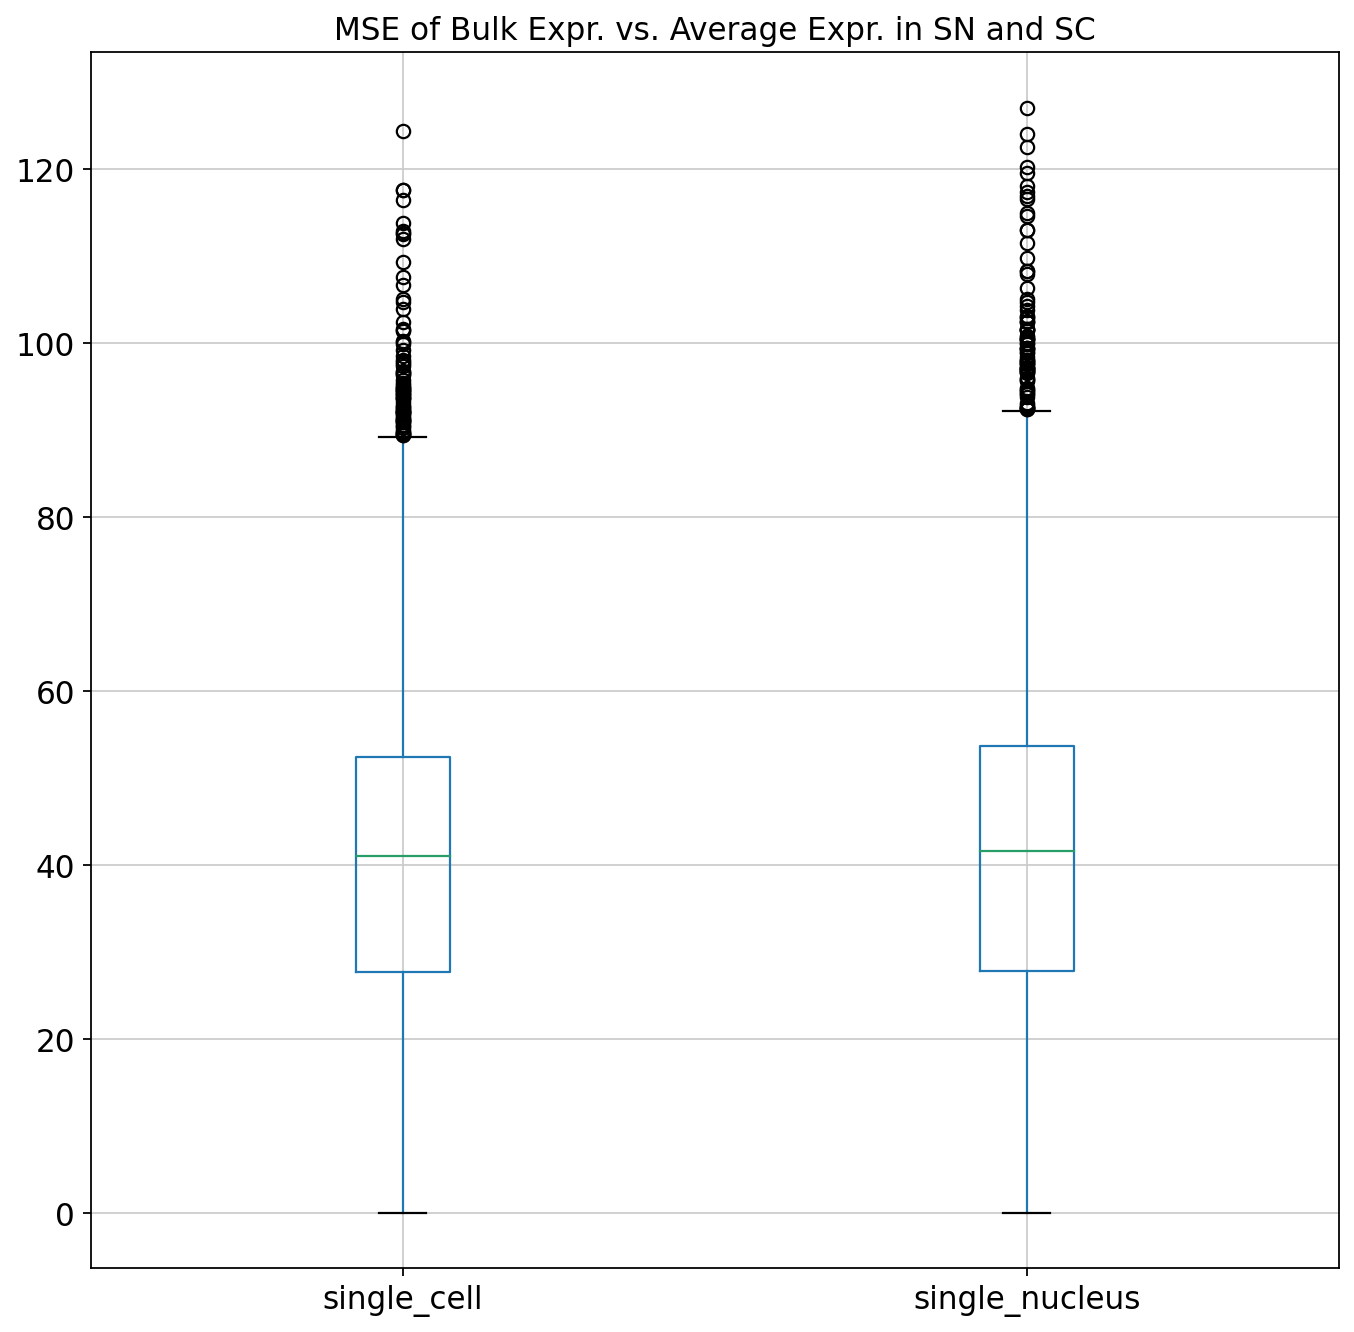

In [ ]:
plt.figure(figsize= [10,10])
mse_both.boxplot(column = ['single_cell', 'single_nucleus'])
plt.title('MSE of Bulk Expr. vs. Average Expr. in SN and SC')
#mean square error plot:

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in sc_adata.var_names:
    for cell in matching_celltypes:
        vals_sc  = sc_adata[sc_adata.obs['cell_type'] == cell]
        vals_sc = vals_sc[vals_sc.var_keys==gene]
        sc_vals = vals_sc.X

        vals_sn  = sn_adata[sn_adata.obs['cell_type'] == cell]
        vals_sn = vals_sn[vals_sn.var_keys==gene]
        sn_vals = vals_sn.X

        pear_df_snsc.loc[cell][gene] = pearsonr(sc_vals[0], sn_vals[0])[0]
pear_df_snsc

NameError: name 'sc_adata' is not defined

In [ ]:
pear_df_snsc = pear_df_snsc.astype('float')
pear_df_snsc = pear_df_snsc.transpose()

In [ ]:
pear_df_snsc.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
plt.title('Pear of SN vs. SC per Common Gene')

TypeError: 'tuple' object is not callable

In [ ]:
#sc_adata = sc_adata[:, sc_adata.var.highly_variable]
#sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(sc_adata, max_value=10)

#sc_adata = sc_adata[:, sc_adata.var.highly_variable]
#sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(sn_adata, max_value=10)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
from sklearn.decomposition import PCA
pca_10 = PCA(n_components=10)
pca_X1 = pca_10.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_10.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[ -3.3837447 ,   2.2973542 ,  10.286757  , ...,   1.8602471 ,
          3.797925  ,   0.59261554],
       [-16.598833  , -11.0189085 ,  -7.326261  , ...,  -1.3451372 ,
          0.0796885 ,  -8.100192  ],
       [  3.766697  ,   7.1760626 ,  18.752773  , ...,  -4.137359  ,
        -11.885546  ,  11.390489  ],
       ...,
       [-13.622611  ,  -8.81782   ,  -6.064151  , ...,  -0.35394892,
          1.989917  ,  -7.077202  ],
       [-19.757236  ,  -9.289225  , -10.817537  , ...,   0.16434114,
          0.9212719 , -11.365426  ],
       [ -6.2926908 ,  -8.177665  ,  -9.303875  , ...,   1.0793248 ,
         -0.54384   ,  -0.81692356]], dtype=float32)

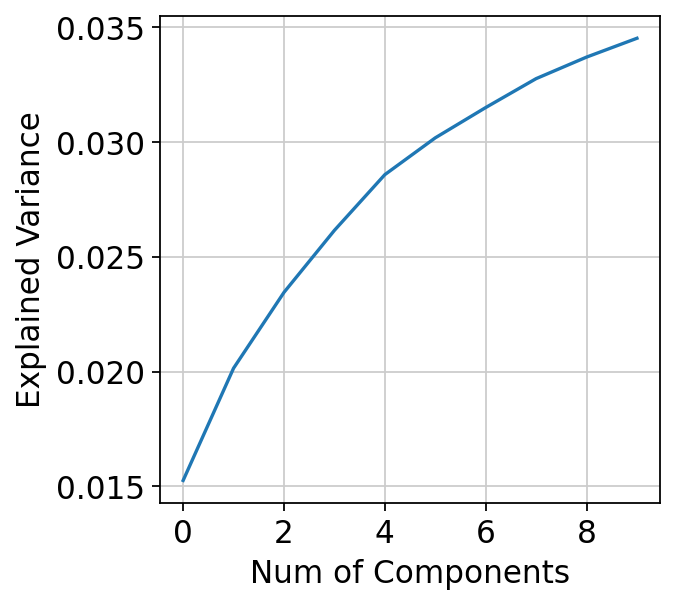

In [ ]:
plt.plot(np.cumsum(pca_10.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_100 = PCA(n_components=100)
pca_X1 = pca_100.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_100.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[-3.3837440e+00,  2.2973514e+00,  1.0286746e+01, ...,
         3.3998799e-01,  1.6081048e+00, -3.0110419e-01],
       [-1.6598827e+01, -1.1018907e+01, -7.3262529e+00, ...,
        -4.7391912e-01,  1.0056594e-01,  4.4368468e-02],
       [ 3.7666953e+00,  7.1760559e+00,  1.8752762e+01, ...,
        -9.0647089e-01, -9.5857292e-01,  1.2263921e+00],
       ...,
       [-1.3622604e+01, -8.8178177e+00, -6.0641465e+00, ...,
         7.6167327e-01,  1.0358659e+00,  1.7822540e-01],
       [-1.9757227e+01, -9.2892208e+00, -1.0817527e+01, ...,
         1.0555808e-01,  5.8777237e-01, -6.0144192e-01],
       [-6.2926879e+00, -8.1776600e+00, -9.3038750e+00, ...,
         2.6061362e-01, -1.1955390e+00, -3.1388570e-03]], dtype=float32)

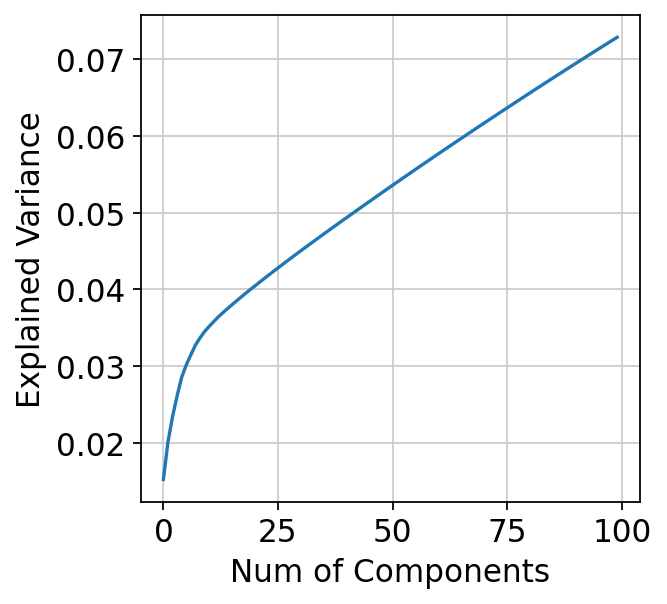

In [ ]:
plt.plot(np.cumsum(pca_100.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_1000 = PCA(n_components=1000)
pca_X1 = pca_1000.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_1000.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[ -3.3837426 ,   2.297367  ,  10.286774  , ...,   1.4188087 ,
         -0.99771535,   0.06333871],
       [-16.59885   , -11.018894  ,  -7.326252  , ...,  -0.2298077 ,
          0.22100928,  -0.14246124],
       [  3.7667062 ,   7.176072  ,  18.752748  , ...,   0.24099213,
         -0.54346967,  -1.2418355 ],
       ...,
       [-13.62262   ,  -8.817809  ,  -6.0641565 , ...,   0.17327508,
         -0.46197745,  -0.03147342],
       [-19.757252  ,  -9.289207  , -10.817515  , ...,   0.35963216,
          0.27972   ,   0.16253902],
       [ -6.2927017 ,  -8.177662  ,  -9.303891  , ...,   0.03546441,
          0.14252406,  -0.59623766]], dtype=float32)

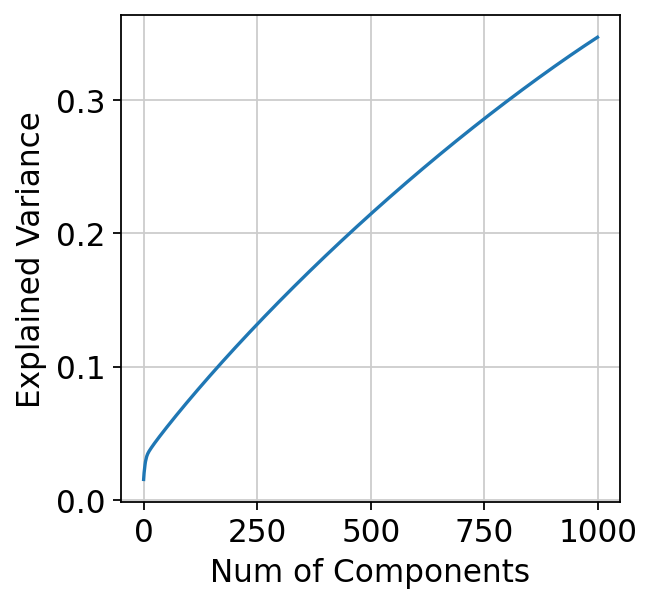

In [ ]:
plt.plot(np.cumsum(pca_1000.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
pca_095 = PCA(n_components=0.95)
pca_X1 = pca_095.fit_transform(sn_adata.X) #sort of like the training dimensions
pca_X2 = pca_095.transform(sc_adata.X)  #fitting sc into sn dimensions
pca_X2

array([[-3.3837473e+00,  2.2973545e+00,  1.0286746e+01, ...,
         6.7381221e-01,  1.4160386e+00, -1.3537028e+00],
       [-1.6598845e+01, -1.1018909e+01, -7.3262510e+00, ...,
        -6.4226997e-01,  1.1660457e-03, -4.1061521e-01],
       [ 3.7667015e+00,  7.1760678e+00,  1.8752764e+01, ...,
        -1.0307285e+00, -2.3528924e+00, -1.9470323e+00],
       ...,
       [-1.3622617e+01, -8.8178186e+00, -6.0641475e+00, ...,
         1.0420792e-01,  2.3048994e-01, -7.8630525e-01],
       [-1.9757246e+01, -9.2892237e+00, -1.0817528e+01, ...,
         5.4506087e-01,  1.9807941e-01, -3.2920268e-01],
       [-6.2926941e+00, -8.1776628e+00, -9.3038721e+00, ...,
         3.0712187e-01,  7.6636231e-01, -5.4683644e-01]], dtype=float32)

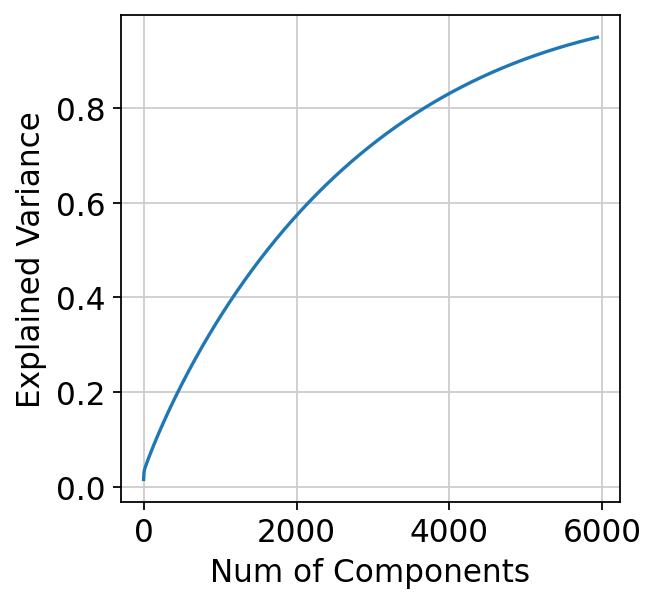

In [ ]:
plt.plot(np.cumsum(pca_095.explained_variance_ratio_))
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
sn_adata.obs['orig']

MJ06_SN_AAACCTGAGATCCCGC    single_nucleus
MJ06_SN_AAACCTGAGCCACTAT    single_nucleus
MJ06_SN_AAACCTGAGCGTGAAC    single_nucleus
MJ06_SN_AAACCTGAGTACGCGA    single_nucleus
MJ06_SN_AAACCTGCAACACCTA    single_nucleus
                                 ...      
MJ06_SN_TTTGTCAGTGCAACGA    single_nucleus
MJ06_SN_TTTGTCAGTTCCATGA    single_nucleus
MJ06_SN_TTTGTCATCCTACAGA    single_nucleus
MJ06_SN_TTTGTCATCGCGATCG    single_nucleus
MJ06_SN_TTTGTCATCTGACCTC    single_nucleus
Name: orig, Length: 8611, dtype: object